# Data Import

In [84]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
import warnings
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

In [2]:
gain_loss = pd.read_excel('GAIN_LOSS_HISTORY.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
book_inv = pd.read_excel('BOOK_INVENTORY_HISTORY.xls')

In [4]:
tank1 = pd.read_excel('TANK1.xlsx')

In [5]:
columns_to_keep_gain_loss = [ 'TERMINAL_PRODUCT_NUMBER', 'FOLIO_NUMBER', 'TANK_CODE', 'OPENING_PHYSICAL', 'BULK_RECEIPTS', 'RACK_DISPOSALS', 'CLOSING_PHYSICAL', 'GAIN_LOSS', 'RACK_FRAC_DISPOSALS', 'OPENING_LEVEL', 'CLOSING_LEVEL', 'OPENING_TOV', 'CLOSING_TOV', 'INVENTORY_QUANTITY_TYPE']

In [6]:
columns_to_keep_book_inv = ['FOLIO_NUMBER','SI_TERMINAL_PRODUCT_NUMBER','OPENING_INVENTORY','INVENTORY_QUANTITY_TYPE','OPENING_FRAC_INVENTORY','CLOSING_INVENTORY','CLOSING_FRAC_INVENTORY','FOLIO_RECEIPTS','FOLIO_FRAC_RECEIPTS','FOLIO_DISPOSALS','FOLIO_FRAC_DISPOSALS']

In [7]:
columns_to_keep_tank1 = ['TANK_CODE','NAME','SHELL_CAPACITY','TERMINAL_PRODUCT_NUMBER']

In [8]:
# Keep specific columns
tank1 = tank1[columns_to_keep_tank1]

In [9]:
# Keep specific columns
book_inv = book_inv[columns_to_keep_book_inv]

In [10]:
# Keep specific columns
gain_loss = gain_loss[columns_to_keep_gain_loss]

In [11]:
gain_loss

TERMINAL_PRODUCT_NUMBER  FOLIO_NUMBER TANK_CODE  OPENING_PHYSICAL  \
0                            1      20210927    TK-301                 0   
1                            1      20210928    TK-301           7885065   
2                            1      20210929    TK-301           7874531   
3                            1      20210930    TK-301           7877551   
4                            1      20210931    TK-301           7874126   
...                        ...           ...       ...               ...   
21770                       13      20240114    TK-400              2493   
21771                       13      20240115    TK-400              2493   
21772                       13      20240116    TK-400              2493   
21773                       13      20240117    TK-400              2493   
21774                       13      20240118    TK-400              2493   

       BULK_RECEIPTS  RACK_DISPOSALS  CLOSING_PHYSICAL  GAIN_LOSS  \
0                  0               0           7885065    7885065   
1                  0               0           7874531     -10534   
2                  0               0           7877551       3020   
3                  0               0           7874126      -3425   
4                  0               0           7874126          0   
...              ...             ...               ...        ...   
21770              0               0              2493          0   
21771              0               1              2493          2   
21772              0               0              2493          0   
21773              0               1              2493          2   
21774              0               1              2493          2   

       RACK_FRAC_DISPOSALS  OPENING_LEVEL  CLOSING_LEVEL  OPENING_TOV  \
0                        0              0           6242            0   
1                        0           6242           6229     10237344   
2                        0           6229           6226     10216668   
3                        0           6226           6227     10211889   
4                        0           6227           6227     10213482   
...                    ...            ...            ...          ...   
21770                    0           1000           1000         2500   
21771                  797           1000           1000         2500   
21772                    0           1000           1000         2500   
21773                  506           1000           1000         2500   
21774                  802           1000           1000         2500   

       CLOSING_TOV  INVENTORY_QUANTITY_TYPE  
0         10237344                        3  
1         10216668                        3  
2         10211889                        3  
3         10213482                        3  
4         10213482                        3  
...            ...                      ...  
21770         2500                        1  
21771         2500                        1  
21772         2500                        1  
21773         2500                        1  
21774         2500                        1  

[21775 rows x 14 columns]

In [12]:
tank1

TANK_CODE           NAME  SHELL_CAPACITY  TERMINAL_PRODUCT_NUMBER
0     TK-100     ADD GO AFR            5000                        8
1     TK-101         GASOIL        40051040                        7
2     TK-102         GASOIL        40052350                        7
3     TK-103         GASOIL        40059210                        7
4     TK-104         GASOIL        27029960                        7
5     TK-105          MOGAS         9529820                        4
6     TK-106          MOGAS         9533050                        4
7     TK-200    ADD MOG AFR            5000                        9
8     TK-201          MOGAS        14380470                        4
9     TK-202          MOGAS        14384200                        4
10    TK-203         GASOIL        27044300                        7
11    TK-204         GASOIL        27060130                        7
12    TK-205         GASOIL        27036170                        7
13    TK-206         GASOIL        27033130                        7
14    TK-300     ADD GO OLA            5000                       12
15    TK-301       FUEL OIL        40201080                        1
16    TK-302            MDO        14381120                        2
17    TK-303   CUTTER STOCK        14385160                        3
18    TK-400    ADD MOG OLA            5000                       13
19    TK-500   ADD GO TOTAL            5000                       10
20    TK-600  ADD MOG TOTAL            5000                       11

In [13]:
# Function to check if a date is valid
def is_valid_date(date):
    if isinstance(date, str):
        date_str = date
    else:
        date_str = str(date)
    
    try:
        pd.to_datetime(date_str[:4] + '-' + date_str[4:6] + '-' + date_str[6:], format='%Y-%m-%d')
        return True
    except ValueError:
        return False

# Filter out rows with invalid dates
gain_loss = gain_loss[gain_loss['FOLIO_NUMBER'].apply(is_valid_date)]

In [14]:
# Find invalid dates
invalid_dates = gain_loss[~gain_loss['FOLIO_NUMBER'].apply(is_valid_date)]

# Print invalid dates
print("Invalid dates:")
print(invalid_dates)

Invalid dates:
Empty DataFrame
Columns: [TERMINAL_PRODUCT_NUMBER, FOLIO_NUMBER, TANK_CODE, OPENING_PHYSICAL, BULK_RECEIPTS, RACK_DISPOSALS, CLOSING_PHYSICAL, GAIN_LOSS, RACK_FRAC_DISPOSALS, OPENING_LEVEL, CLOSING_LEVEL, OPENING_TOV, CLOSING_TOV, INVENTORY_QUANTITY_TYPE]
Index: []


In [15]:
# Convert FOLIO_NUMBER to datetime format
gain_loss['FOLIO_NUMBER'] = pd.to_datetime(gain_loss['FOLIO_NUMBER'], format='%Y%m%d')

In [16]:
gain_loss

TERMINAL_PRODUCT_NUMBER FOLIO_NUMBER TANK_CODE  OPENING_PHYSICAL  \
0                            1   2021-09-27    TK-301                 0   
1                            1   2021-09-28    TK-301           7885065   
2                            1   2021-09-29    TK-301           7874531   
3                            1   2021-09-30    TK-301           7877551   
5                            1   2021-10-01    TK-301           7874126   
...                        ...          ...       ...               ...   
21770                       13   2024-01-14    TK-400              2493   
21771                       13   2024-01-15    TK-400              2493   
21772                       13   2024-01-16    TK-400              2493   
21773                       13   2024-01-17    TK-400              2493   
21774                       13   2024-01-18    TK-400              2493   

       BULK_RECEIPTS  RACK_DISPOSALS  CLOSING_PHYSICAL  GAIN_LOSS  \
0                  0               0           7885065    7885065   
1                  0               0           7874531     -10534   
2                  0               0           7877551       3020   
3                  0               0           7874126      -3425   
5                  0               0           7876232       2106   
...              ...             ...               ...        ...   
21770              0               0              2493          0   
21771              0               1              2493          2   
21772              0               0              2493          0   
21773              0               1              2493          2   
21774              0               1              2493          2   

       RACK_FRAC_DISPOSALS  OPENING_LEVEL  CLOSING_LEVEL  OPENING_TOV  \
0                        0              0           6242            0   
1                        0           6242           6229     10237344   
2                        0           6229           6226     10216668   
3                        0           6226           6227     10211889   
5                        0           6227           6223     10213482   
...                    ...            ...            ...          ...   
21770                    0           1000           1000         2500   
21771                  797           1000           1000         2500   
21772                    0           1000           1000         2500   
21773                  506           1000           1000         2500   
21774                  802           1000           1000         2500   

       CLOSING_TOV  INVENTORY_QUANTITY_TYPE  
0         10237344                        3  
1         10216668                        3  
2         10211889                        3  
3         10213482                        3  
5         10207111                        3  
...            ...                      ...  
21770         2500                        1  
21771         2500                        1  
21772         2500                        1  
21773         2500                        1  
21774         2500                        1  

[21100 rows x 14 columns]

In [17]:
# Select the desired columns
desired_columns = ['FOLIO_NUMBER', 'TERMINAL_PRODUCT_NUMBER', 'TANK_CODE', 'CLOSING_PHYSICAL']

# Create a new DataFrame with only the desired columns
gainloss = gain_loss[desired_columns].copy()

# Display the first few rows of the new DataFrame
print(gainloss.head())

  FOLIO_NUMBER  TERMINAL_PRODUCT_NUMBER TANK_CODE  CLOSING_PHYSICAL
0   2021-09-27                        1    TK-301           7885065
1   2021-09-28                        1    TK-301           7874531
2   2021-09-29                        1    TK-301           7877551
3   2021-09-30                        1    TK-301           7874126
5   2021-10-01                        1    TK-301           7876232


In [327]:
print(sorted(gainloss['TANK_CODE'].unique()))

['TK-100', 'TK-101', 'TK-102', 'TK-103', 'TK-104', 'TK-105', 'TK-106', 'TK-200', 'TK-201', 'TK-202', 'TK-203', 'TK-204', 'TK-205', 'TK-206', 'TK-300', 'TK-301', 'TK-302', 'TK-303', 'TK-304', 'TK-305', 'TK-306', 'TK-307', 'TK-400', 'TK-500', 'TK-600']


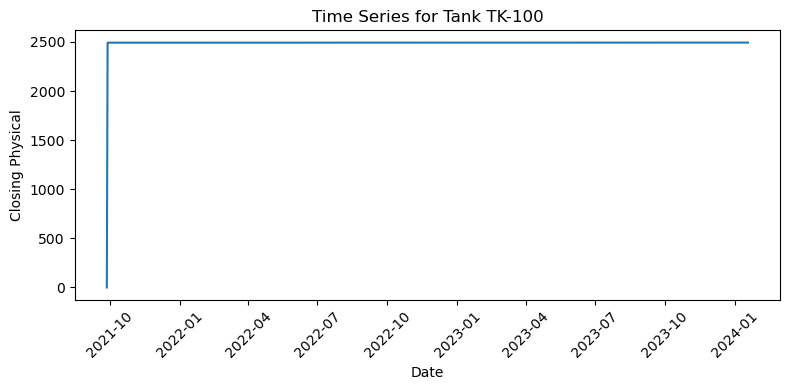

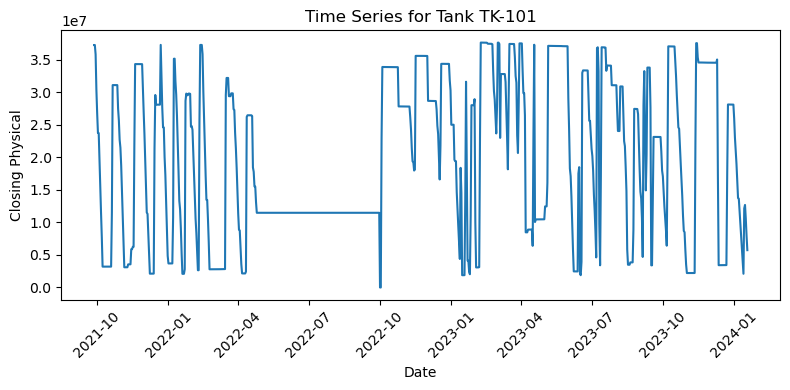

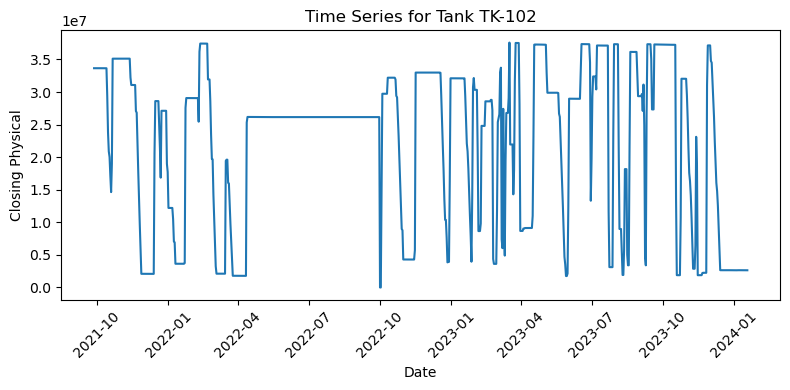

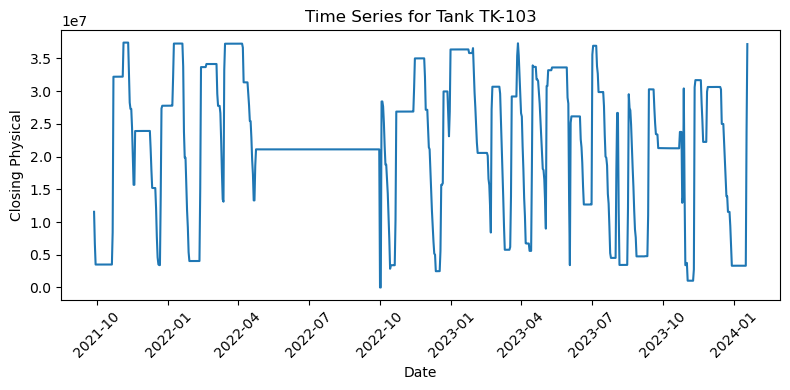

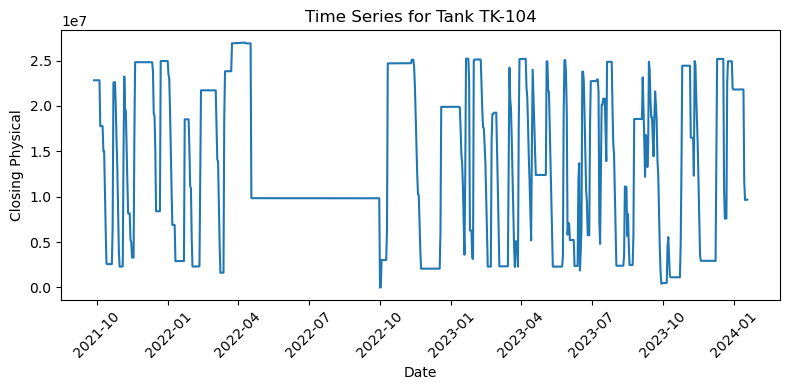

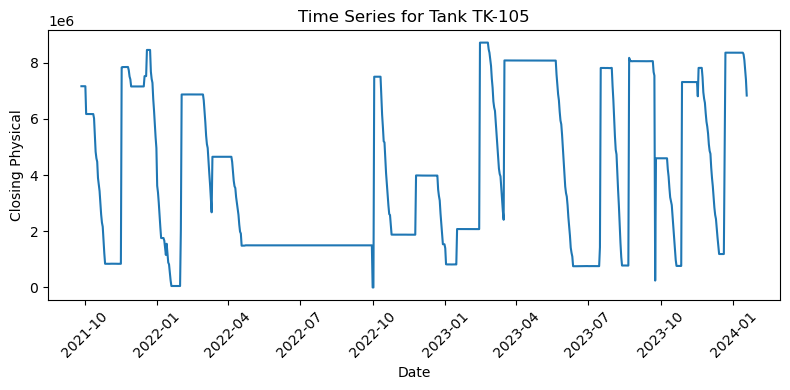

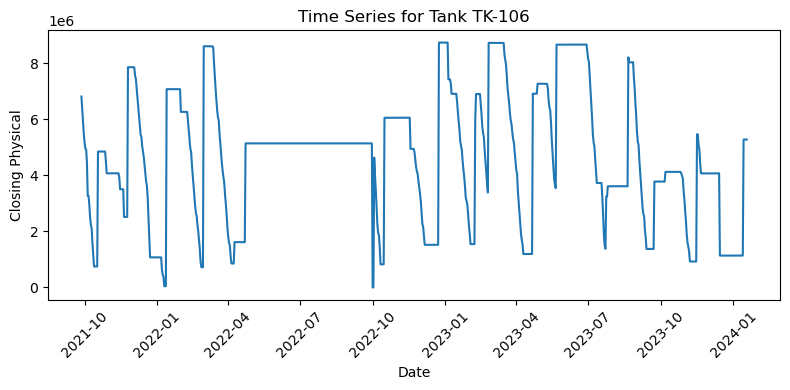

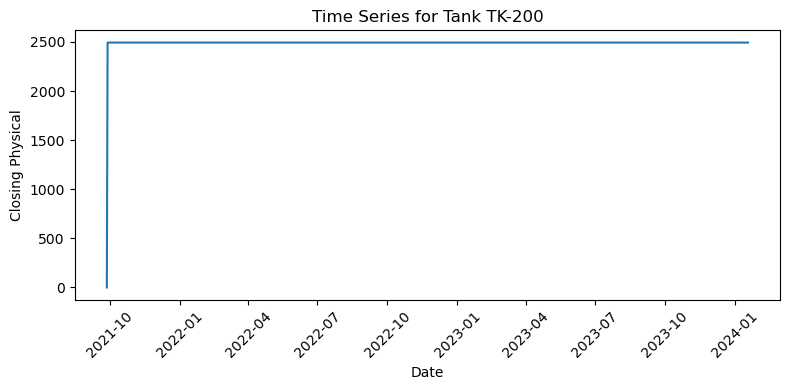

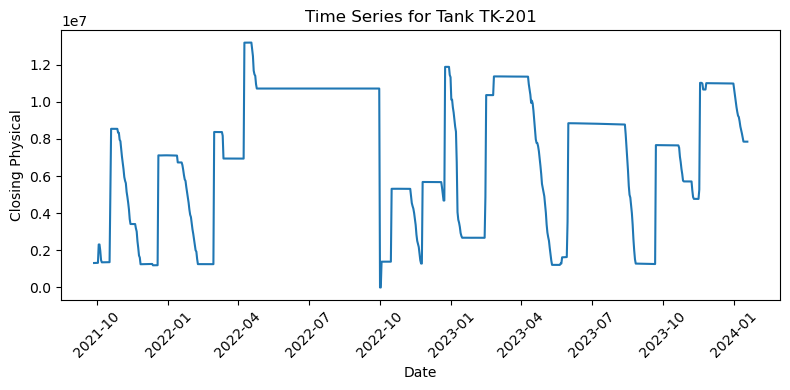

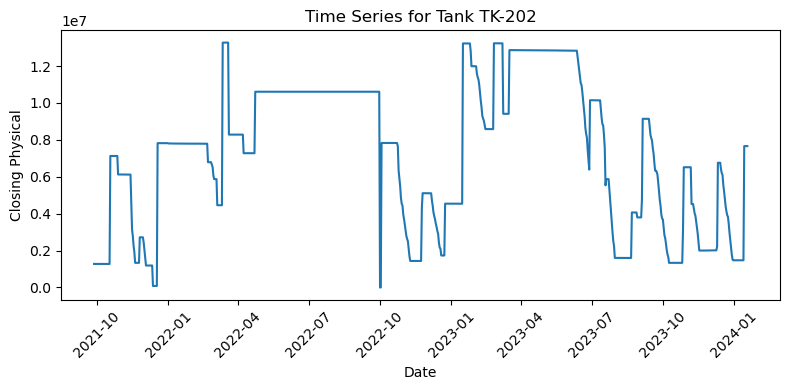

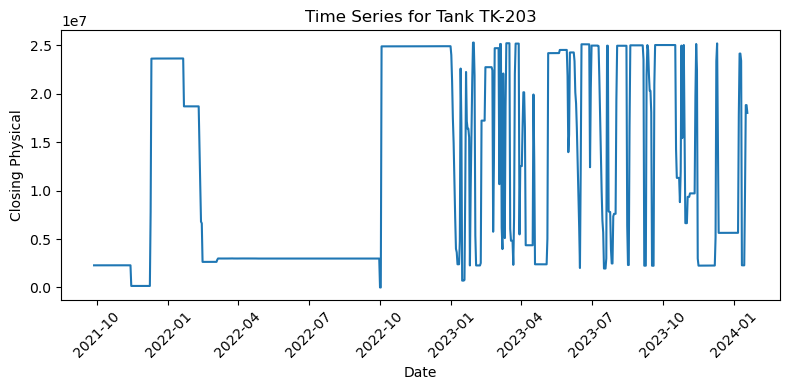

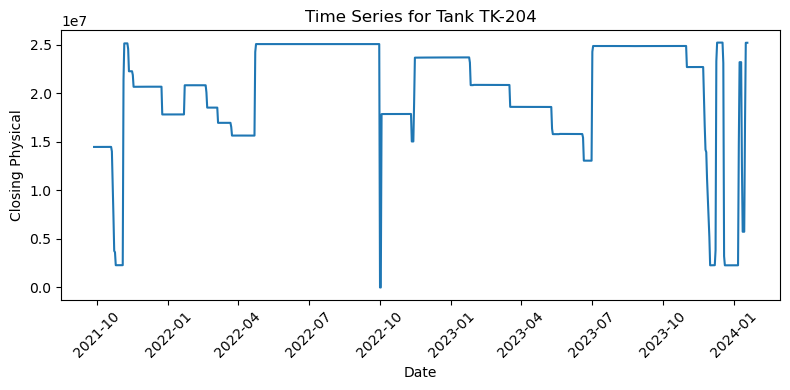

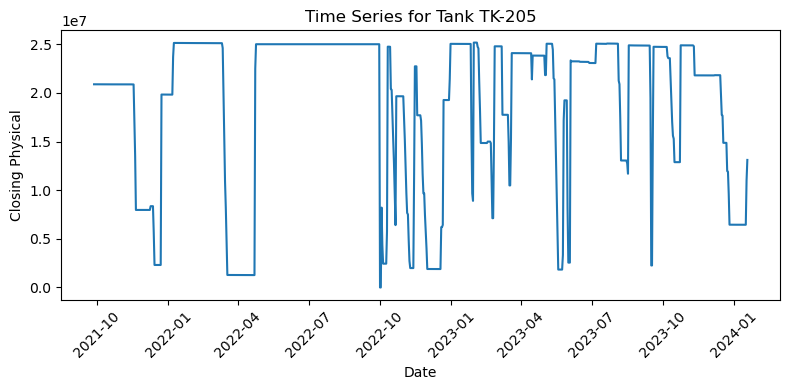

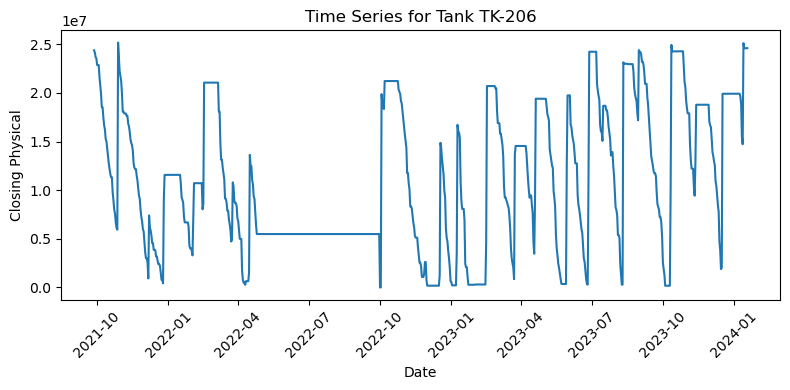

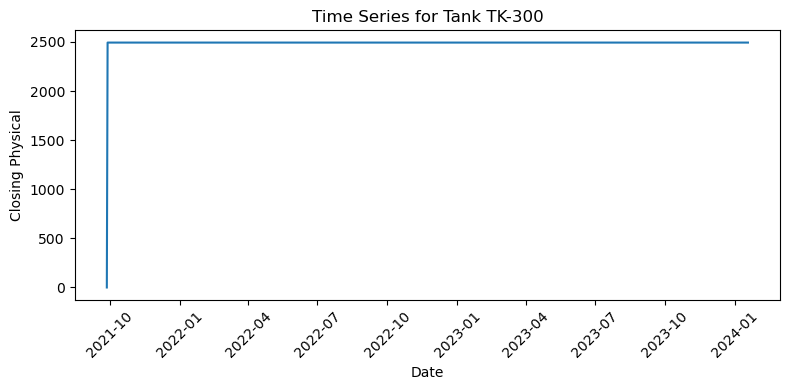

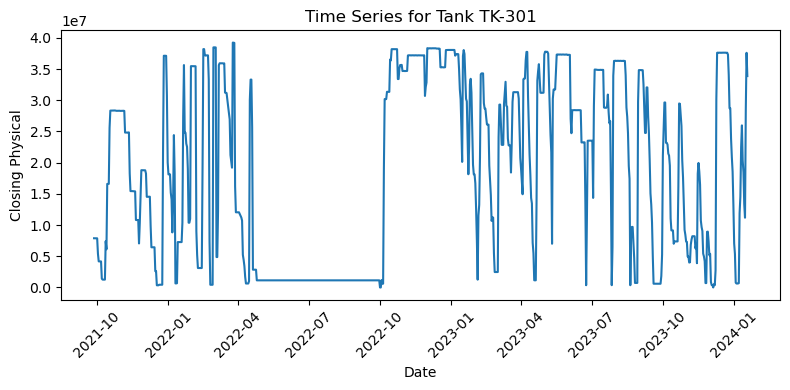

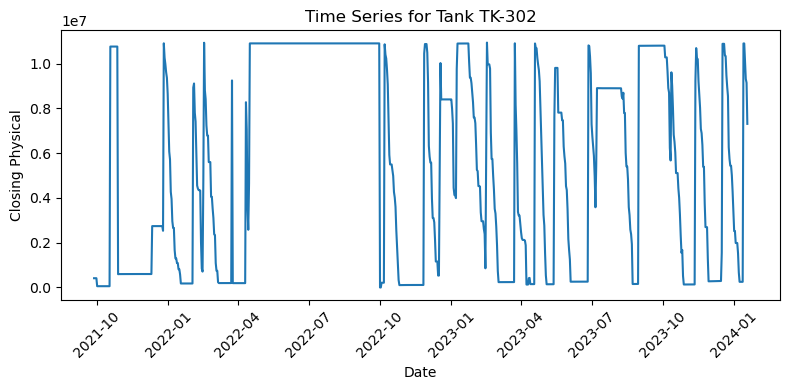

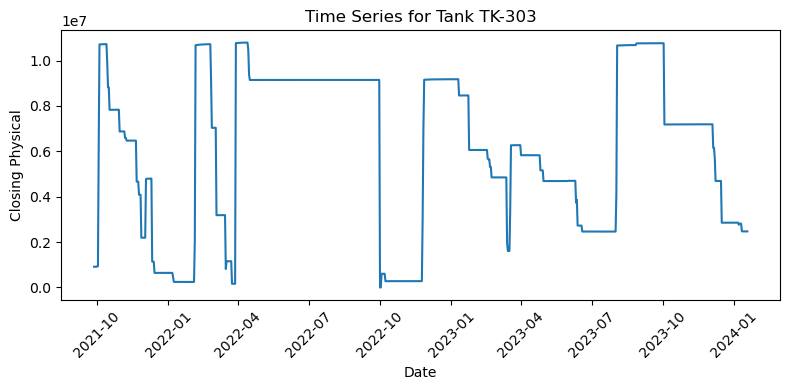

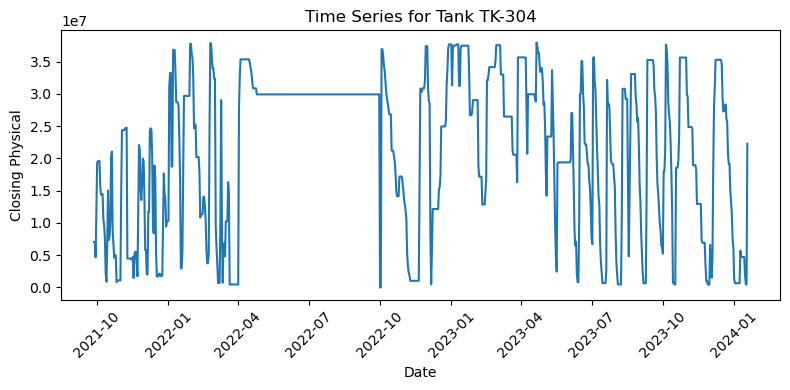

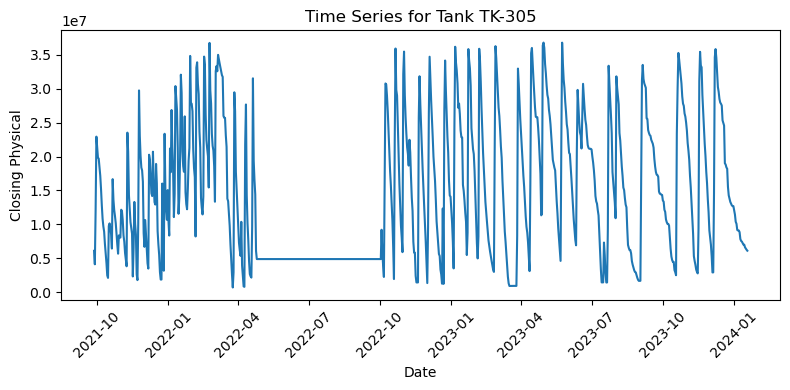

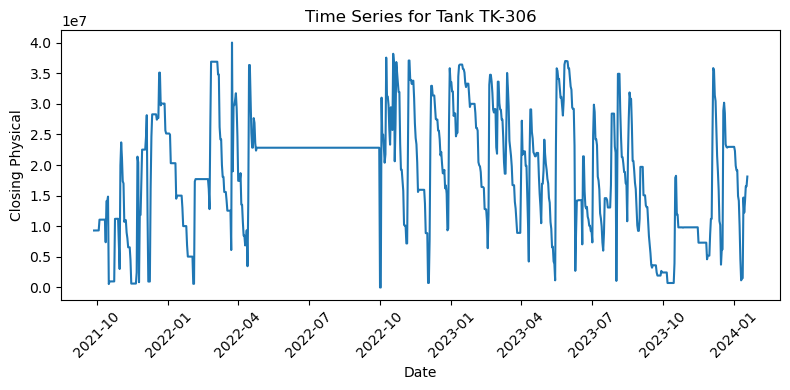

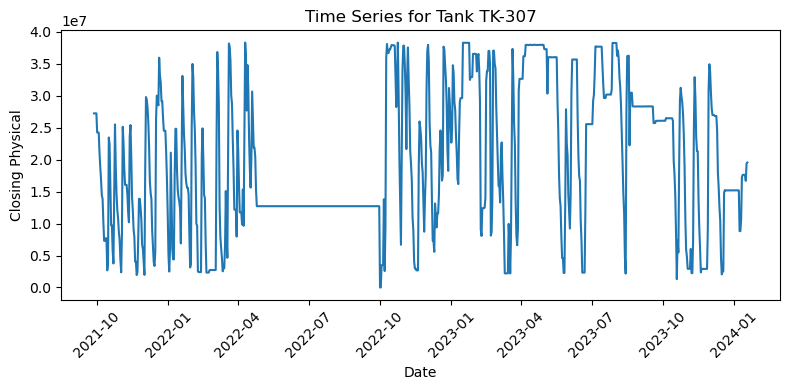

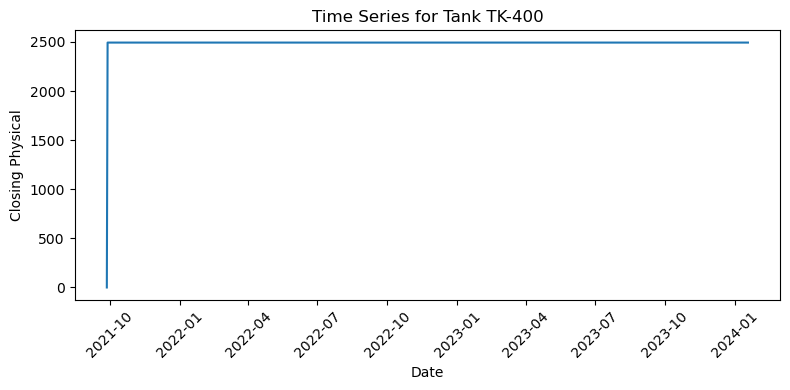

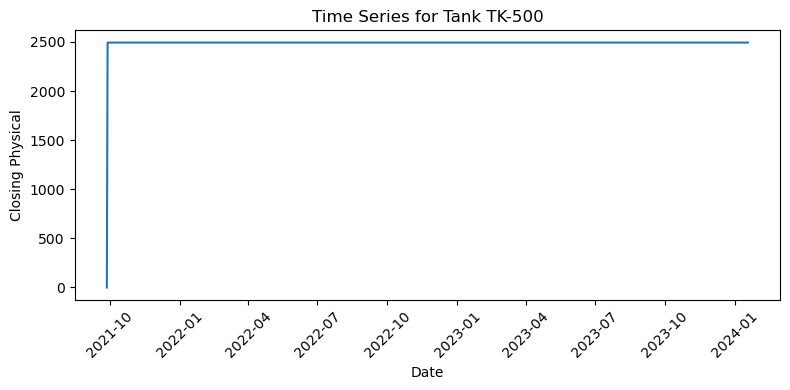

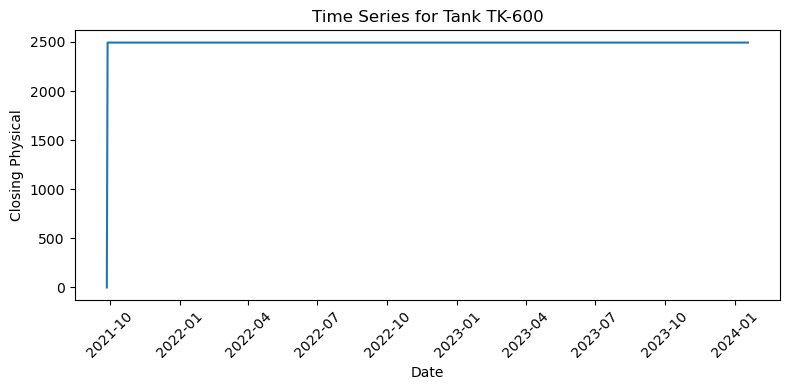

In [19]:

# Assuming gain_loss is your DataFrame containing the data
# Convert 'DATE' column to datetime if it's not already in datetime format
gainloss['FOLIO_NUMBER'] = pd.to_datetime(gainloss['FOLIO_NUMBER'])

# Group the data by 'TANK_CODE'
grouped_data = gainloss.groupby('TANK_CODE')

# Plot time series for each tank
for tank_code, tank_data in grouped_data:
    plt.figure(figsize=(8, 4))
    plt.plot(tank_data['FOLIO_NUMBER'], tank_data['CLOSING_PHYSICAL'])
    plt.title(f'Time Series for Tank {tank_code}')
    plt.xlabel('Date')
    plt.ylabel('Closing Physical')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# TK-101

In [101]:
# Filter the DataFrame for entries with tank code 'TK-101'
tank_101_data = gainloss[gainloss['TANK_CODE'] == 'TK-101']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_101_data['FOLIO_NUMBER'] = pd.to_datetime(tank_101_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_101_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_101_data_monthly = tank_101_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.3090362368011455


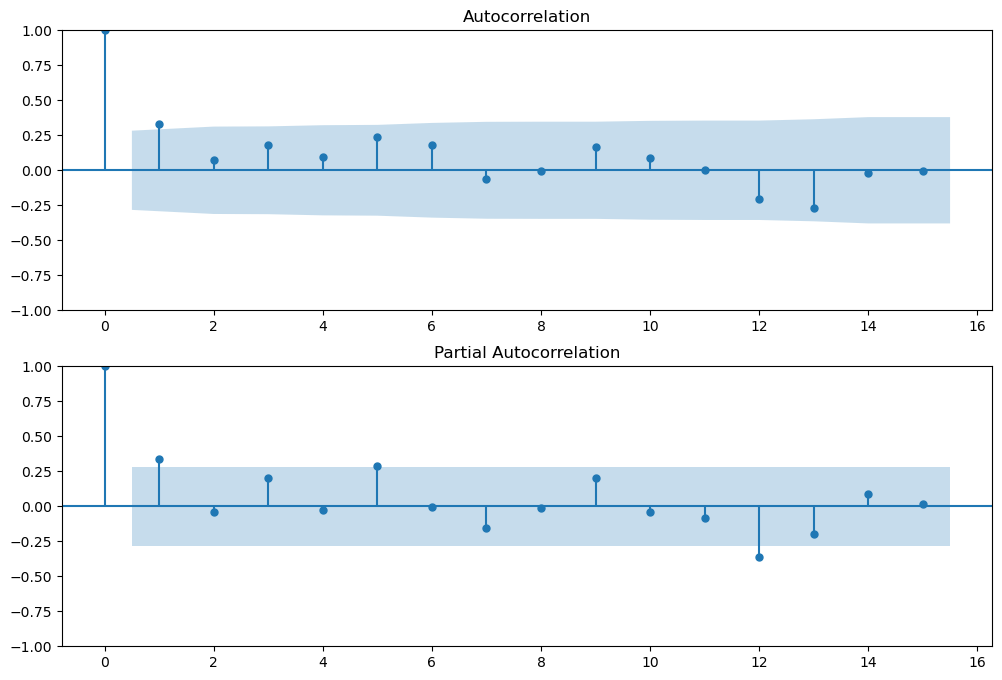

In [130]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_101_data_monthly)
print('p-value:', result[1])

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_101_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_101_data_monthly.iloc[13:], lags=15, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 339677515.1356624


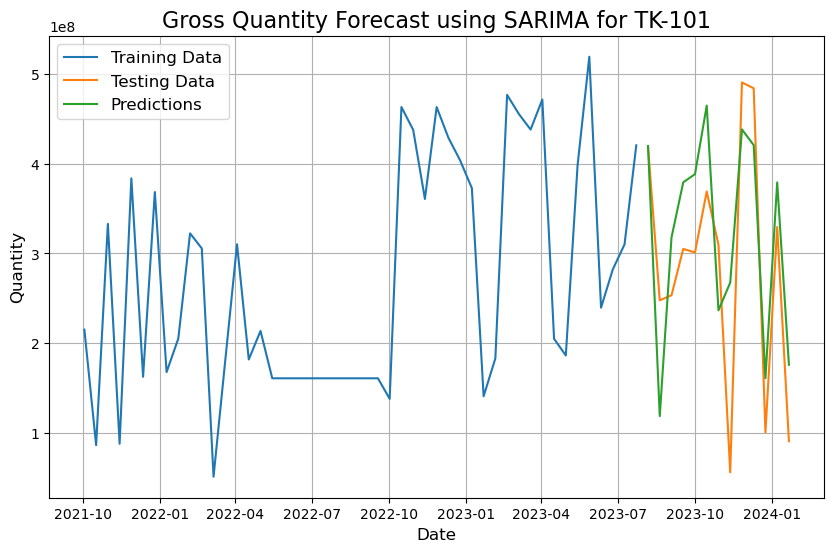

In [132]:
train, test = train_test_split(tank_101_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_101_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(12, 1,1), seasonal_order=(1,0,1,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-101', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

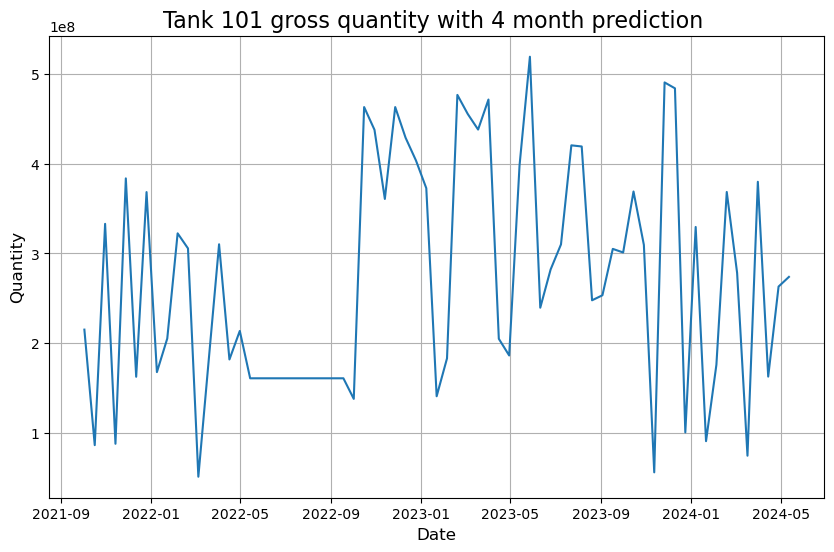

In [133]:
# Extract the last date (index)
last_date_index = tank_101_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_101_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(12, 1,1), seasonal_order=(1,0,1,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 101 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-102

In [87]:
# Filter the DataFrame for entries with tank code 'TK-102'
tank_102_data = gainloss[gainloss['TANK_CODE'] == 'TK-102']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_102_data['FOLIO_NUMBER'] = pd.to_datetime(tank_102_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_102_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_102_data_monthly = tank_102_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 4.683528748974168e-06


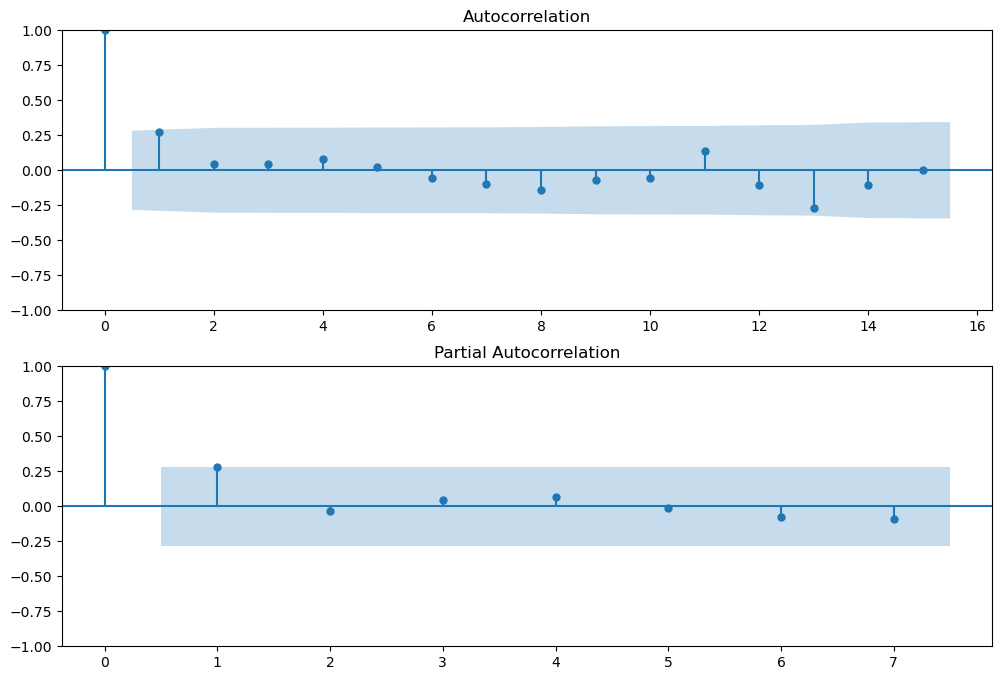

In [96]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_102_data_monthly)
print('p-value:', result[1])
# Data is stationnary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_102_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_102_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 288728599.4785361


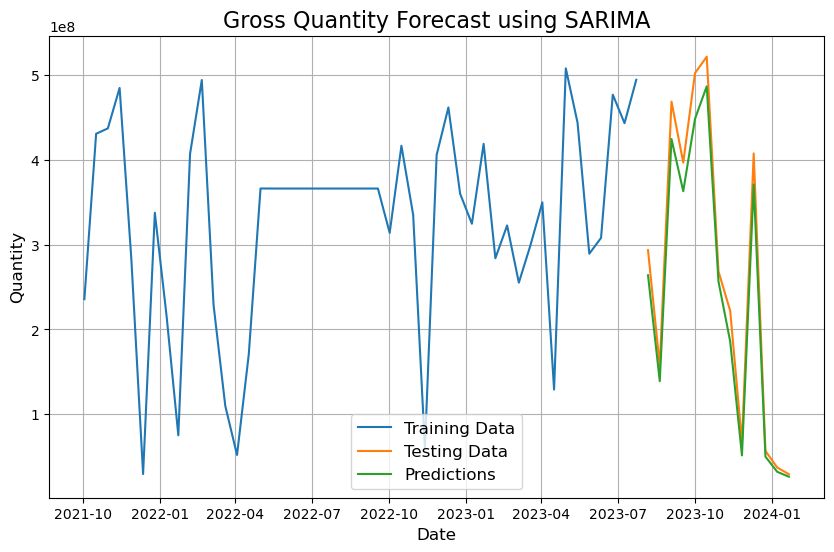

In [100]:
train, test = train_test_split(tank_102_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_102_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

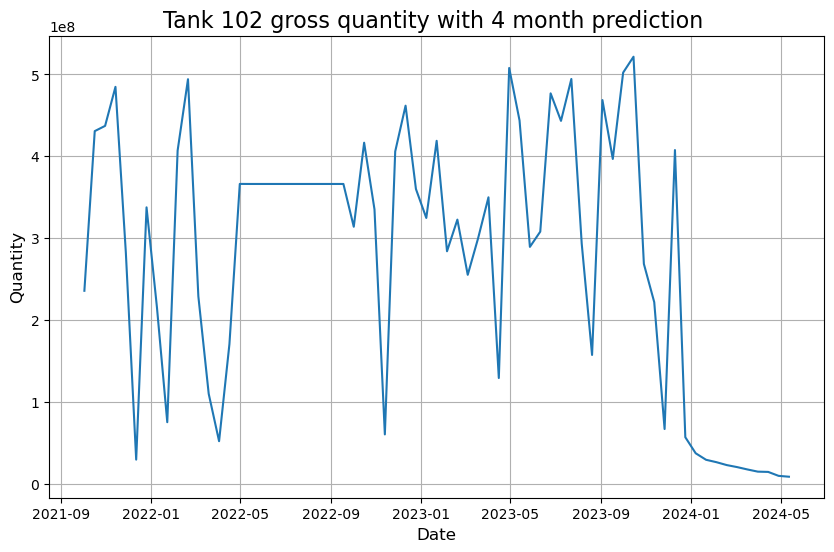

In [90]:
# Extract the last date (index)
last_date_index = tank_102_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])


# Initial training data
train_data = tank_102_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 102 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-103

In [107]:
# Filter the DataFrame for entries with tank code 'TK-103'
tank_103_data = gainloss[gainloss['TANK_CODE'] == 'TK-103']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_103_data['FOLIO_NUMBER'] = pd.to_datetime(tank_103_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_103_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_103_data_monthly = tank_103_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 2.6090707647409875e-07


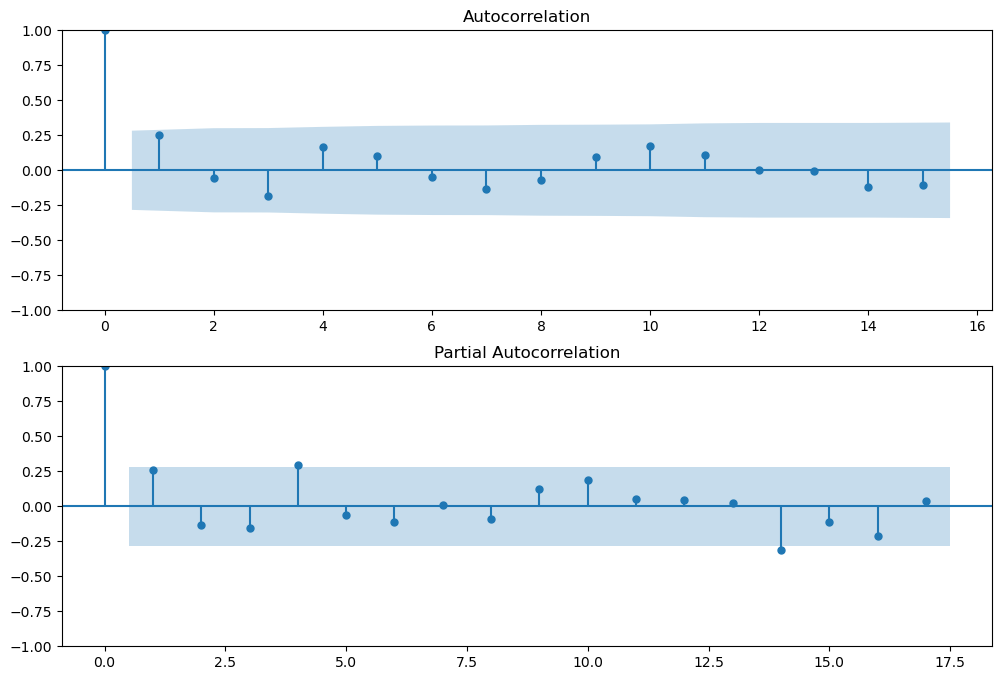

In [134]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_103_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_103_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_103_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 230962865.11798972


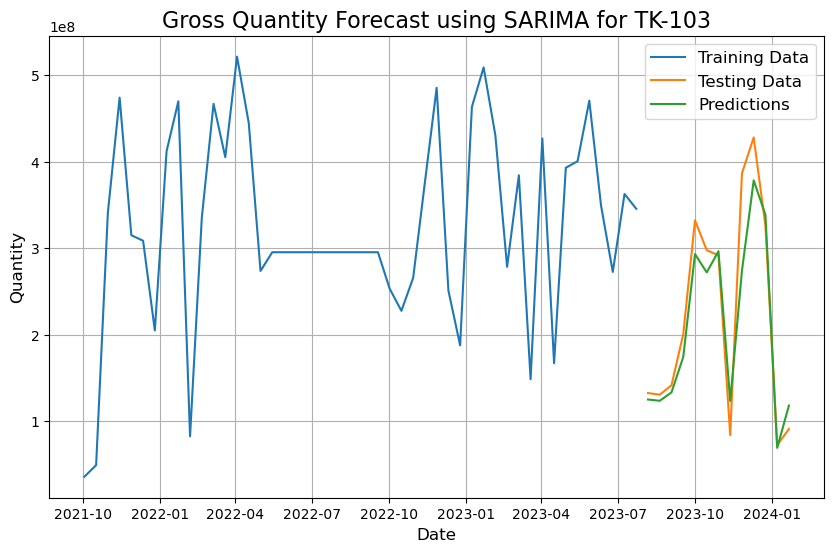

In [148]:
train, test = train_test_split(tank_103_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_103_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,1,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-103', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

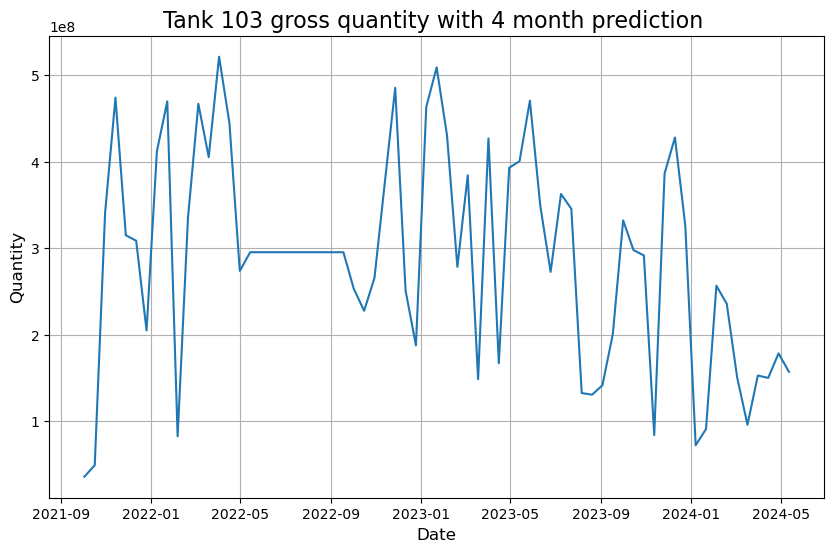

In [150]:
# Extract the last date (index)
last_date_index = tank_103_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_103_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(4, 0,0), seasonal_order=(1,0,1,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 103 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-104

In [151]:
# Filter the DataFrame for entries with tank code 'TK-104'
tank_104_data = gainloss[gainloss['TANK_CODE'] == 'TK-104']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_104_data['FOLIO_NUMBER'] = pd.to_datetime(tank_104_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_104_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_104_data_monthly = tank_104_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.00018808827426400397


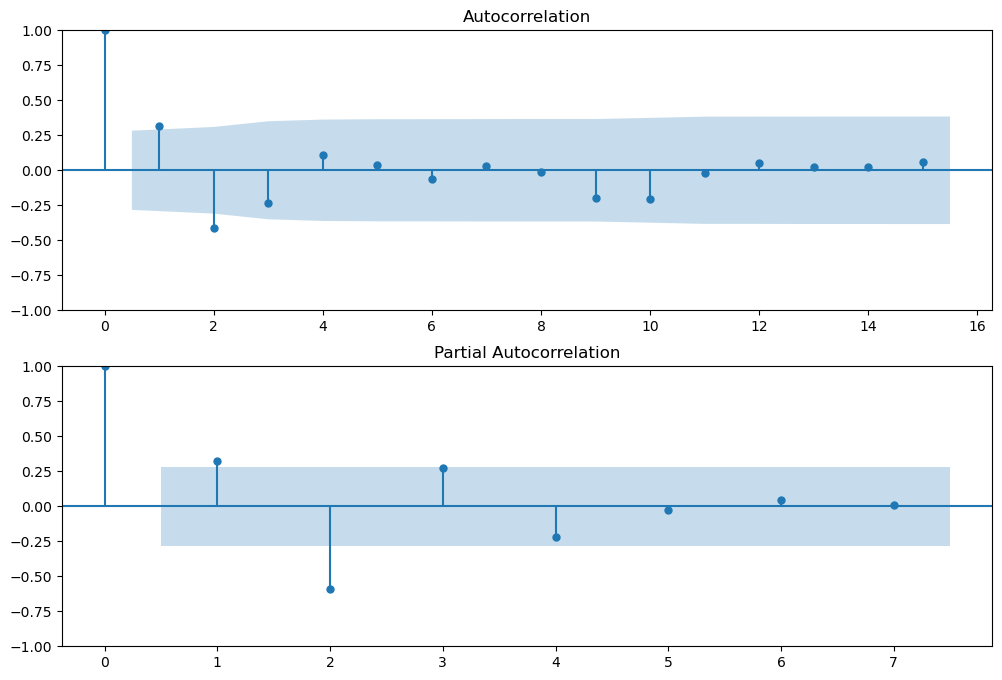

In [152]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_104_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_104_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_104_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 178884863.73761877


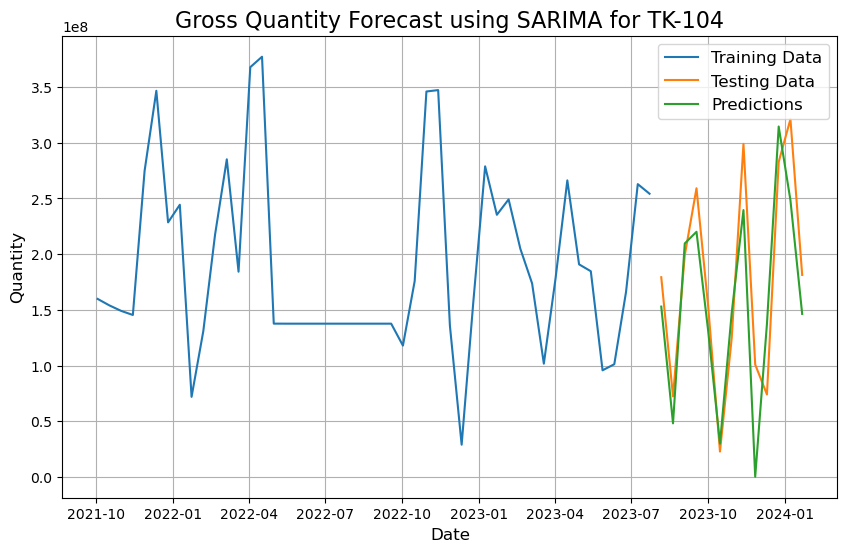

In [163]:
train, test = train_test_split(tank_104_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_104_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(2, 0,1), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-104', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

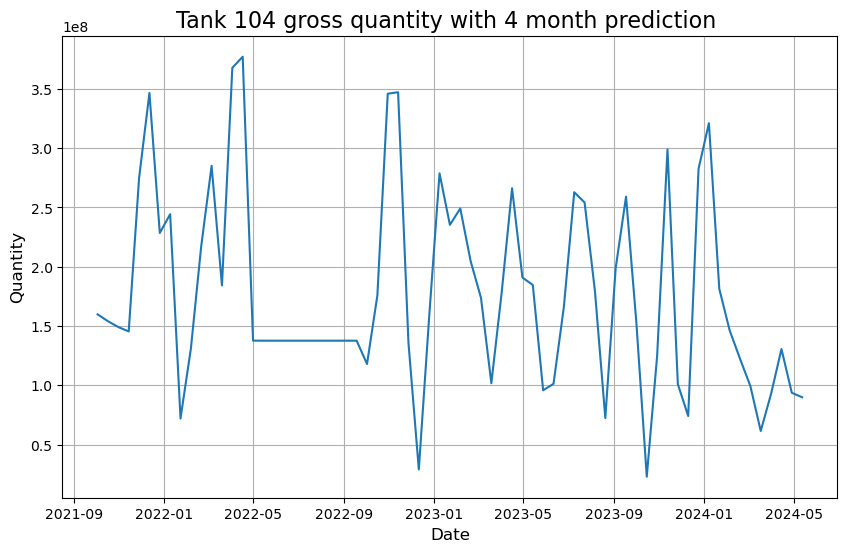

In [161]:
# Extract the last date (index)
last_date_index = tank_104_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_104_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(2, 0,1), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 104 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-105

In [167]:
# Filter the DataFrame for entries with tank code 'TK-105'
tank_105_data = gainloss[gainloss['TANK_CODE'] == 'TK-105']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_105_data['FOLIO_NUMBER'] = pd.to_datetime(tank_105_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_105_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_105_data_monthly = tank_105_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.00036364701474813233


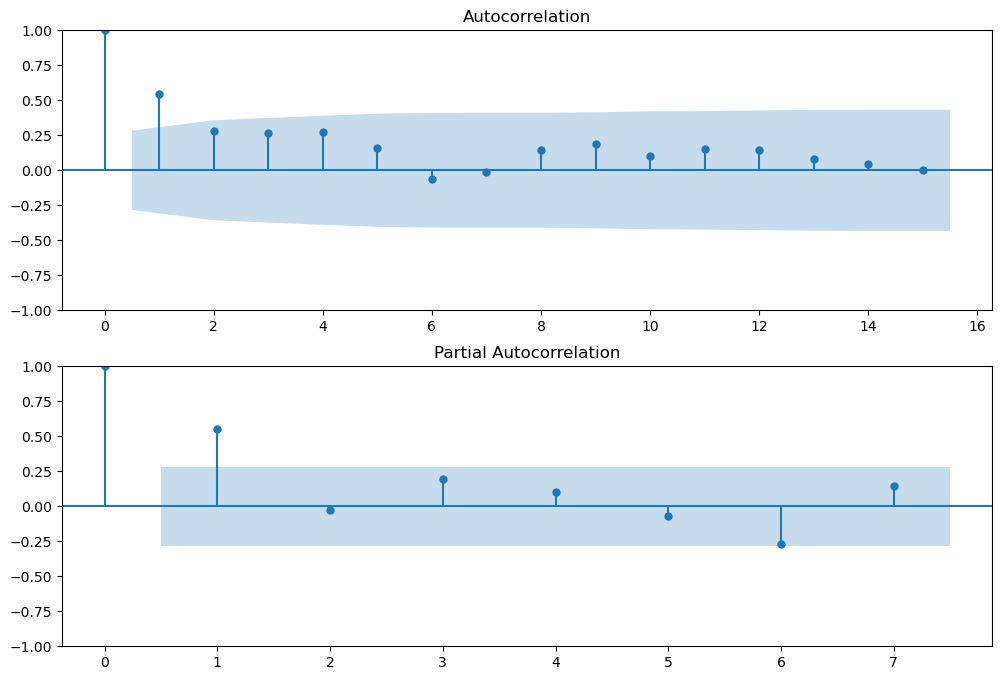

In [168]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_105_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_105_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_105_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 74309534.50030892


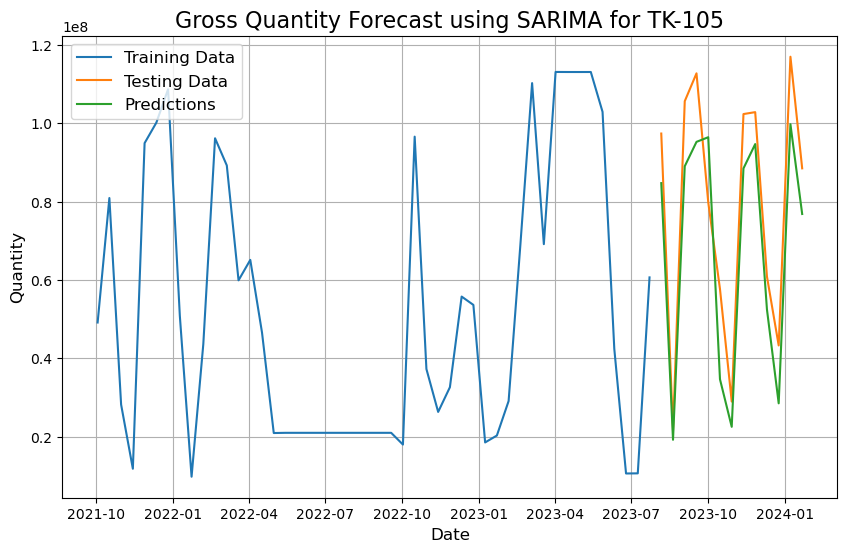

In [169]:
train, test = train_test_split(tank_105_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_105_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-105', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

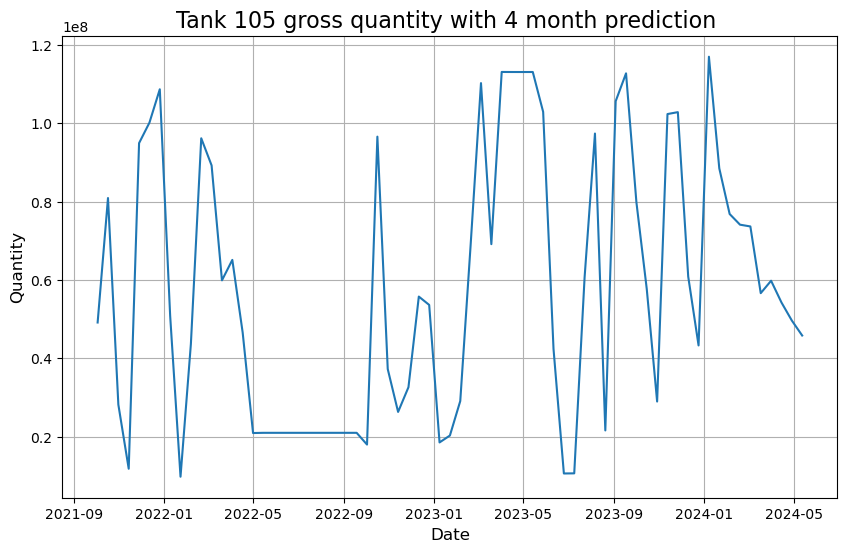

In [170]:
# Extract the last date (index)
last_date_index = tank_105_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_105_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 105 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-106

In [172]:
# Filter the DataFrame for entries with tank code 'TK-106'
tank_106_data = gainloss[gainloss['TANK_CODE'] == 'TK-106']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_106_data['FOLIO_NUMBER'] = pd.to_datetime(tank_106_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_106_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_106_data_monthly = tank_106_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.023387340403735465


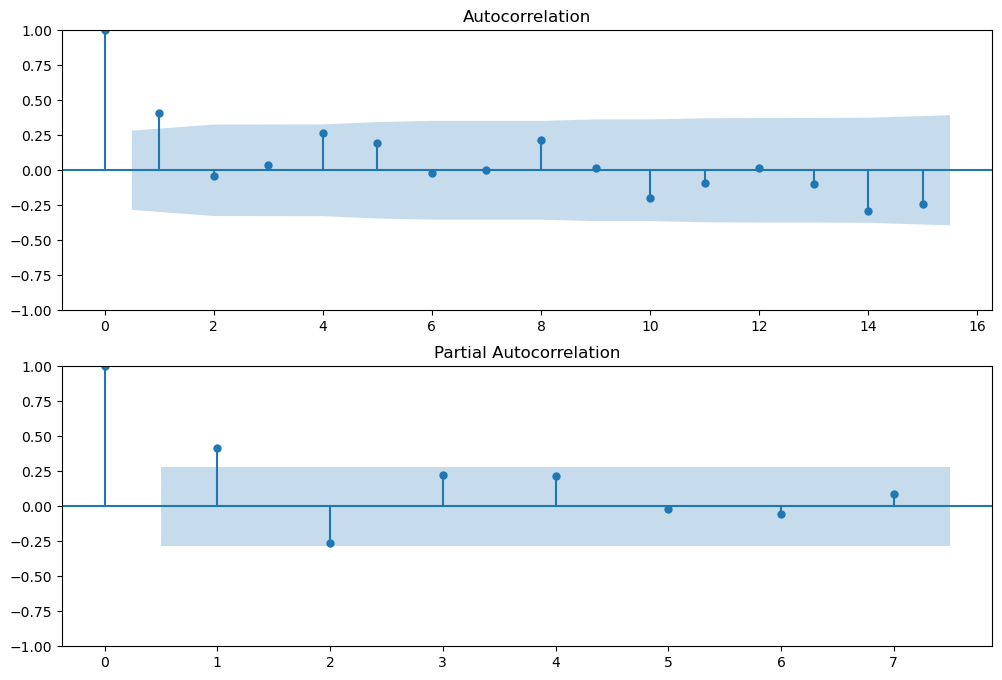

In [173]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_106_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_106_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_106_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 45309558.41611761


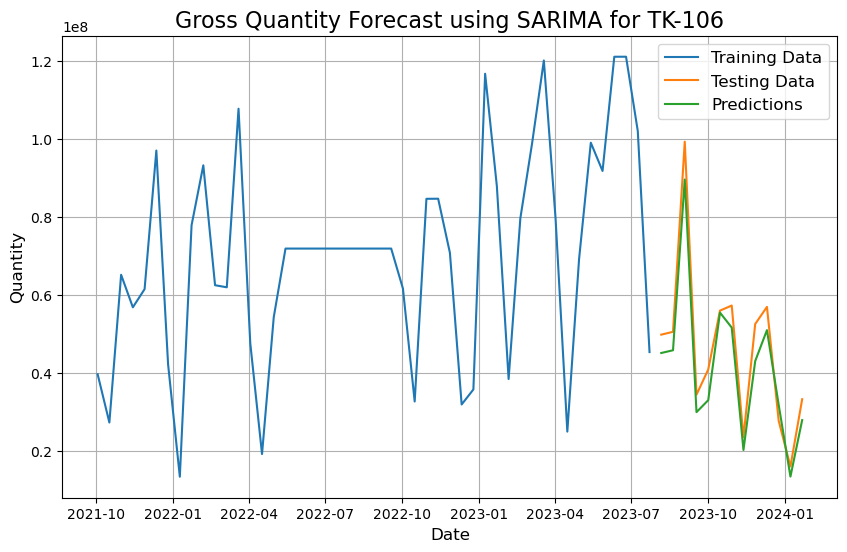

In [181]:
train, test = train_test_split(tank_106_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_106_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-106', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

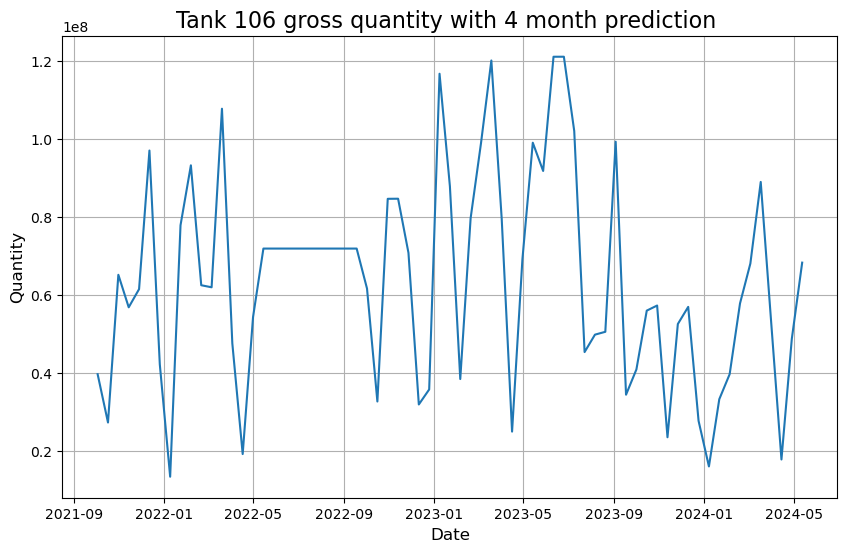

In [178]:
# Extract the last date (index)
last_date_index = tank_106_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_106_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,1,1,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 106 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-201

In [187]:
# Filter the DataFrame for entries with tank code 'TK-201'
tank_201_data = gainloss[gainloss['TANK_CODE'] == 'TK-201']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_201_data['FOLIO_NUMBER'] = pd.to_datetime(tank_201_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_201_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_201_data_monthly = tank_201_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.00012959896035966376


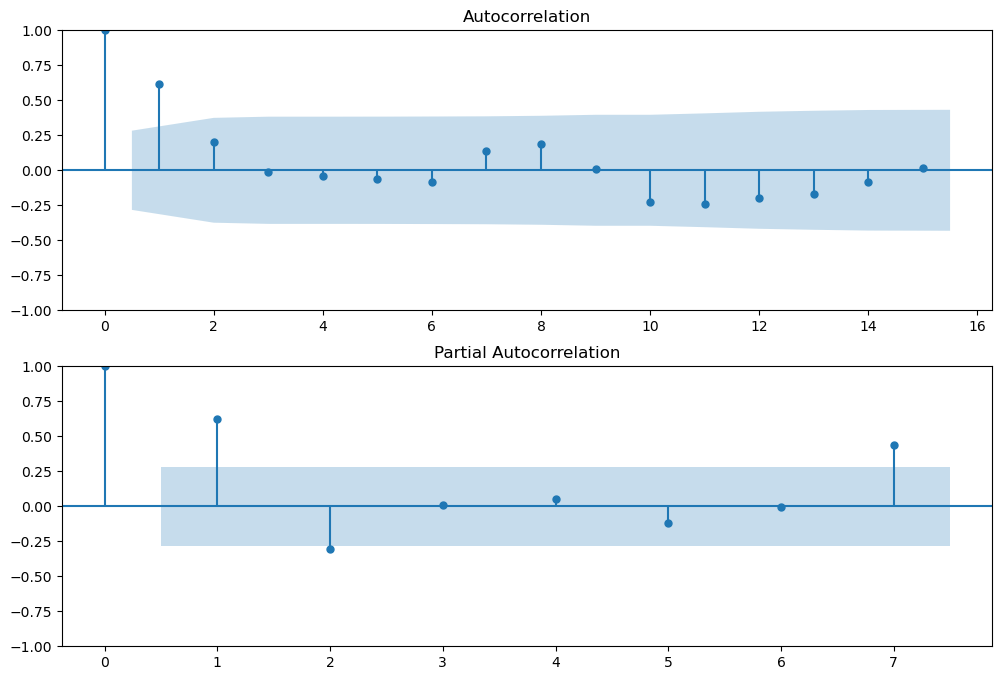

In [188]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_201_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_201_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_201_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 99587068.70151512


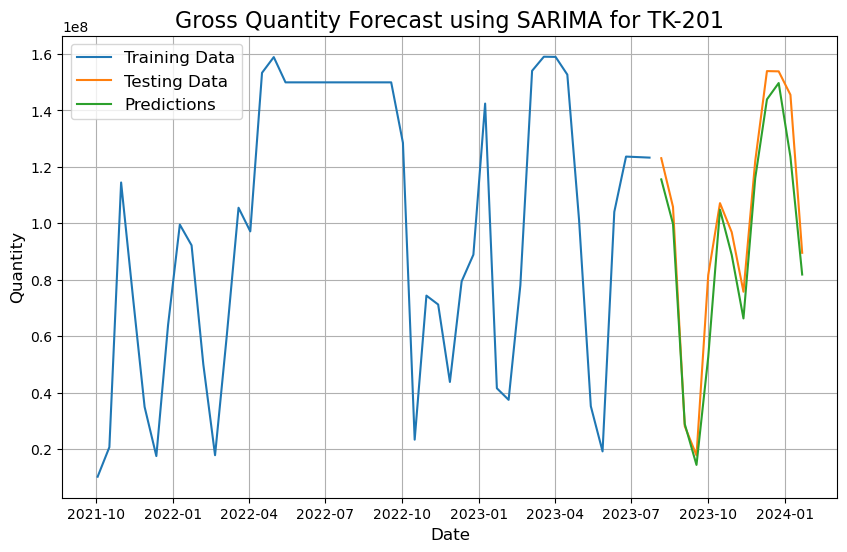

In [189]:
train, test = train_test_split(tank_201_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_201_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-201', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

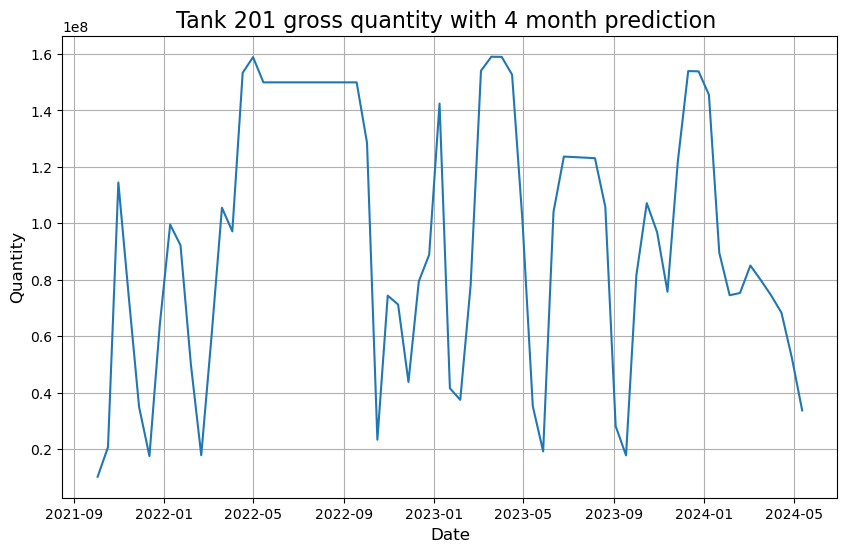

In [191]:
# Extract the last date (index)
last_date_index = tank_201_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_201_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 201 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-202

In [195]:
# Filter the DataFrame for entries with tank code 'TK-202'
tank_202_data = gainloss[gainloss['TANK_CODE'] == 'TK-202']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_202_data['FOLIO_NUMBER'] = pd.to_datetime(tank_202_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_202_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_202_data_monthly = tank_202_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.07059471965062665


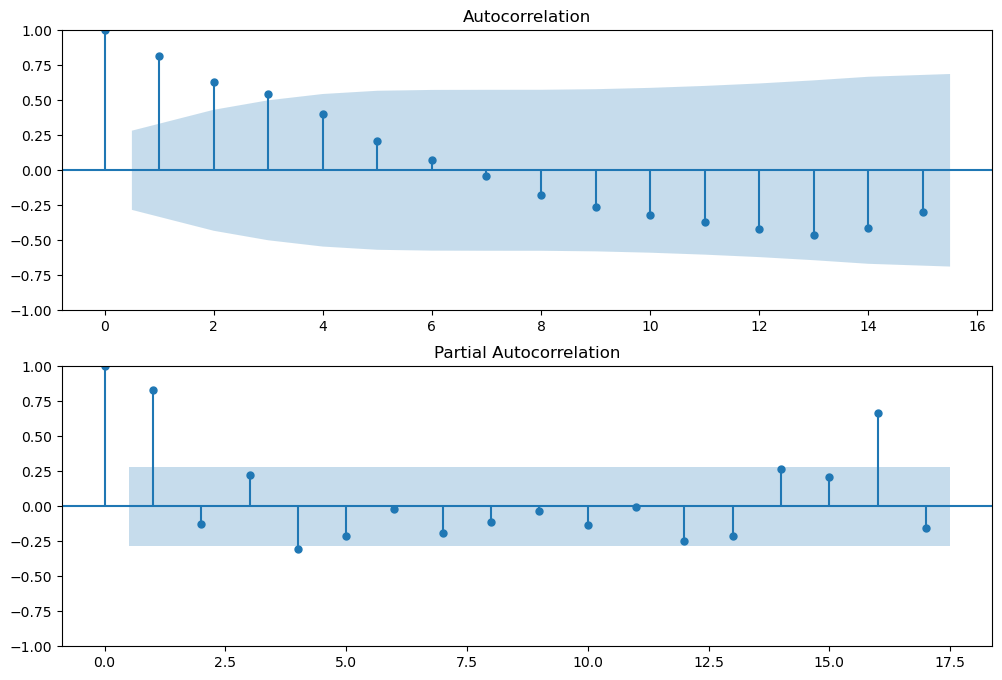

In [206]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_202_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_202_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_202_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 60503644.382392734


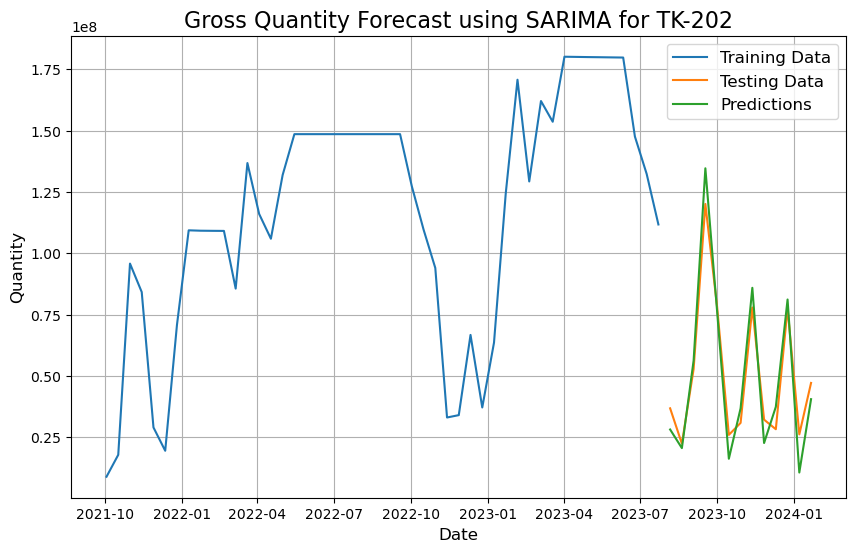

In [222]:
train, test = train_test_split(tank_202_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_202_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 1,0), seasonal_order=(1,0,1,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-202', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

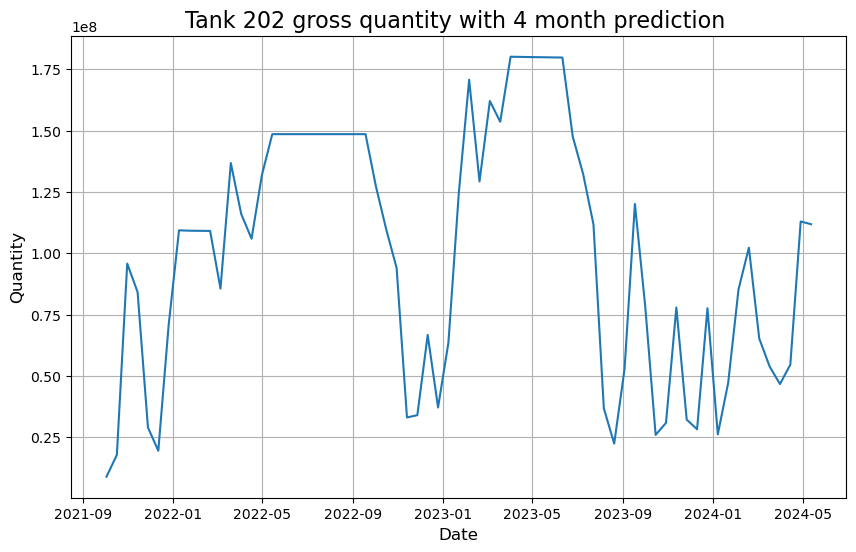

In [224]:
# Extract the last date (index)
last_date_index = tank_202_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_202_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(16, 1,2), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 202 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-203

In [209]:
# Filter the DataFrame for entries with tank code 'TK-203'
tank_203_data = gainloss[gainloss['TANK_CODE'] == 'TK-203']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_203_data['FOLIO_NUMBER'] = pd.to_datetime(tank_203_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_203_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_203_data_monthly = tank_203_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.05811618141320147


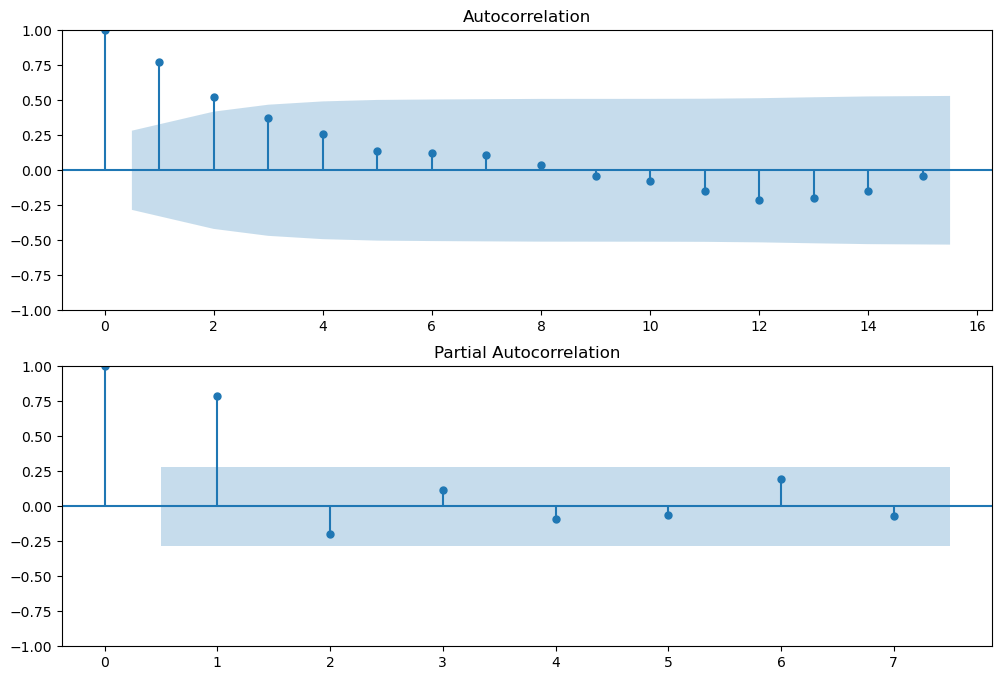

In [210]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_203_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_203_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_203_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 199587582.27952623


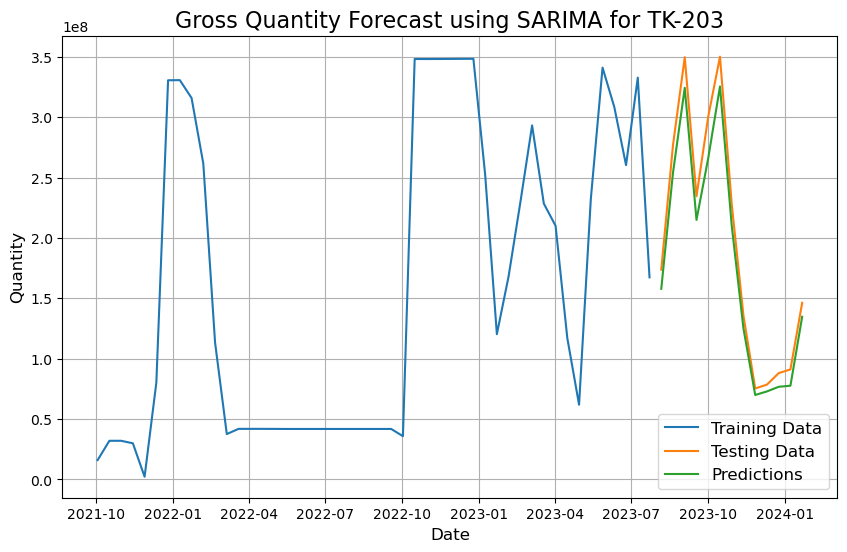

In [211]:
train, test = train_test_split(tank_203_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_203_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-203', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

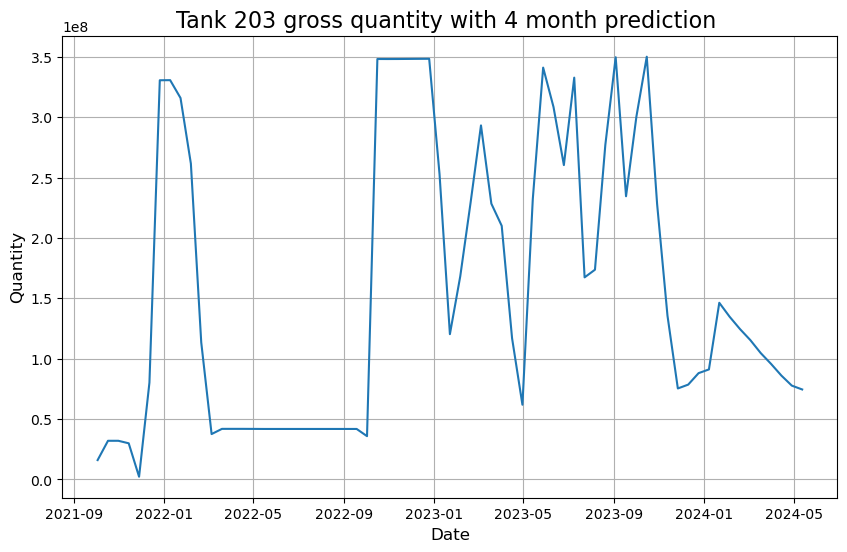

In [212]:
# Extract the last date (index)
last_date_index = tank_203_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_203_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 203 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-204

In [214]:
# Filter the DataFrame for entries with tank code 'TK-204'
tank_204_data = gainloss[gainloss['TANK_CODE'] == 'TK-204']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_204_data['FOLIO_NUMBER'] = pd.to_datetime(tank_204_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_204_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_204_data_monthly = tank_204_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0012909835716326912


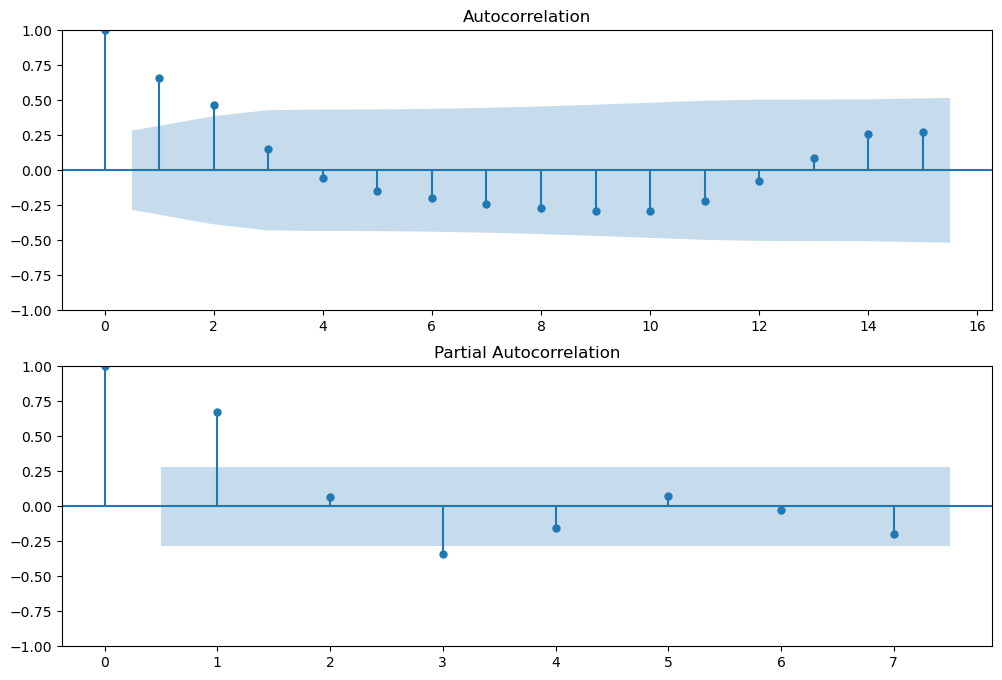

In [215]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_204_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_204_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_204_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 291602435.4911772


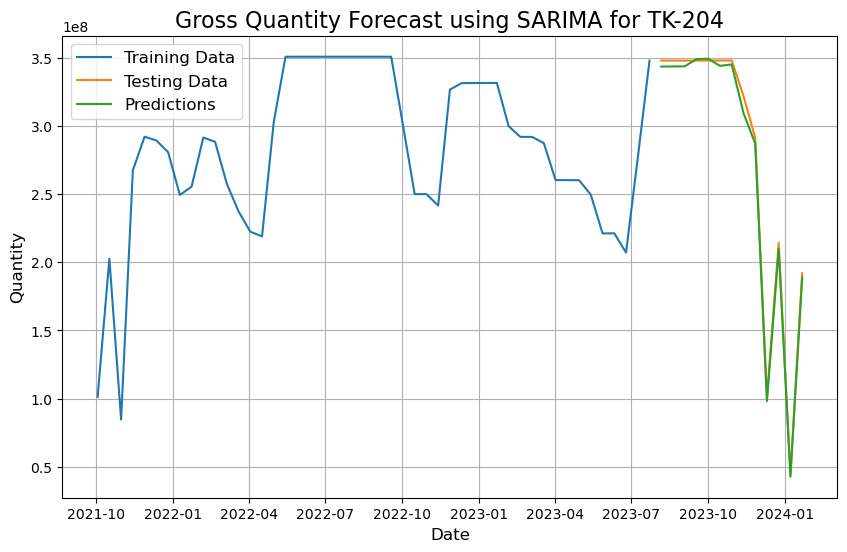

In [232]:
train, test = train_test_split(tank_204_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_204_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-204', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

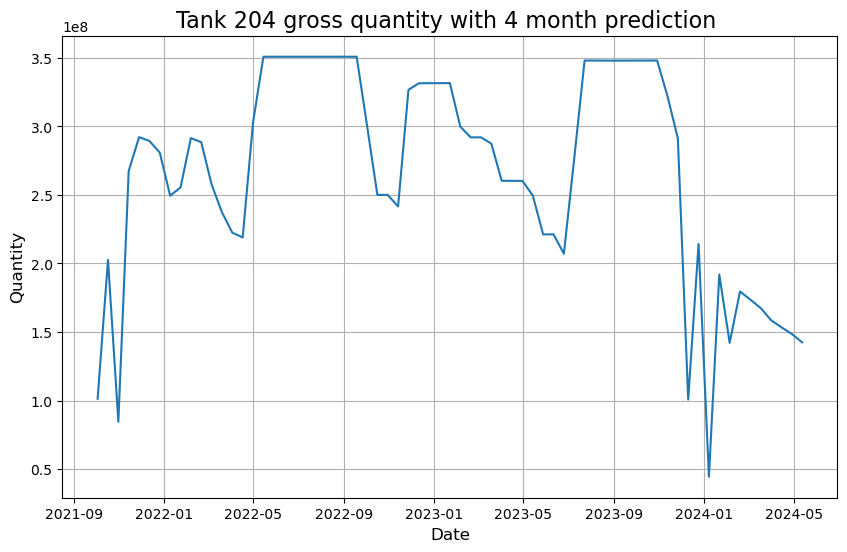

In [234]:
# Extract the last date (index)
last_date_index = tank_204_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_204_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,2), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component //order=(1, 0,0), seasonal_order=(1,0,0,26)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 204 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-205

In [236]:
# Filter the DataFrame for entries with tank code 'TK-205'
tank_205_data = gainloss[gainloss['TANK_CODE'] == 'TK-205']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_205_data['FOLIO_NUMBER'] = pd.to_datetime(tank_205_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_205_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_205_data_monthly = tank_205_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0005827050246586728


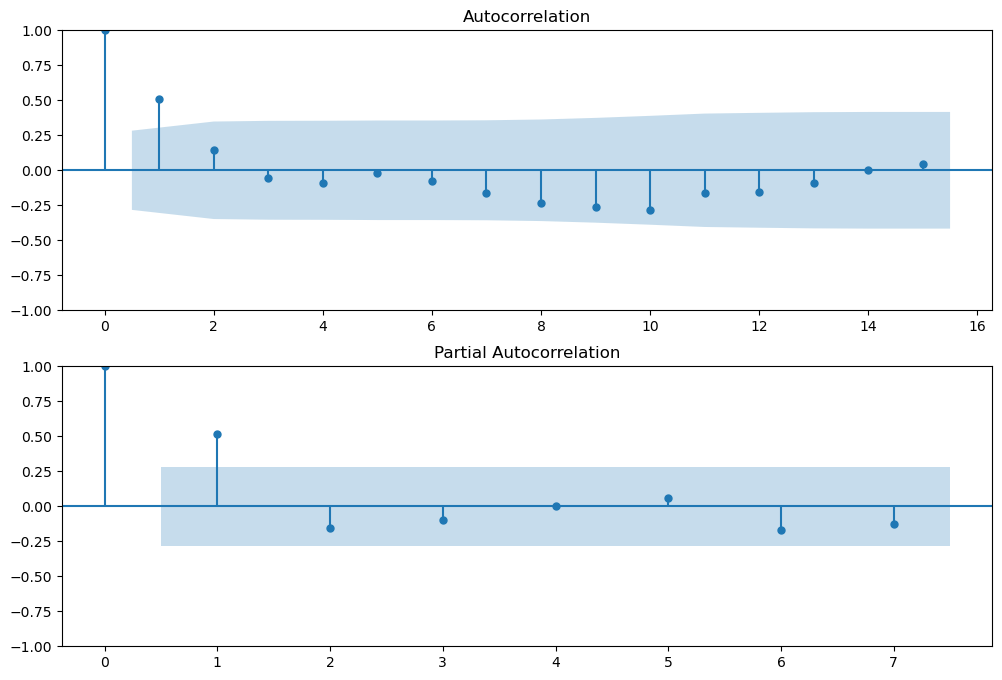

In [237]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_205_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_205_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_205_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 262476815.71693656


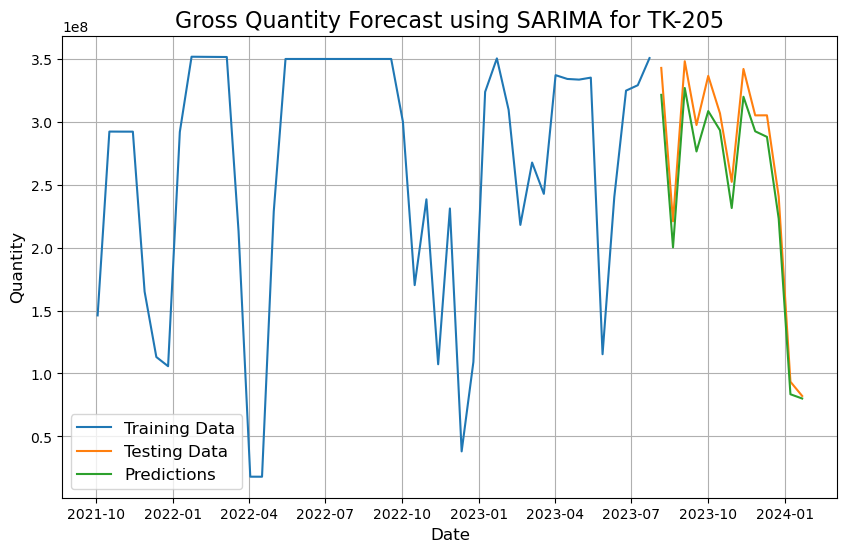

In [245]:
train, test = train_test_split(tank_205_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_205_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-205', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

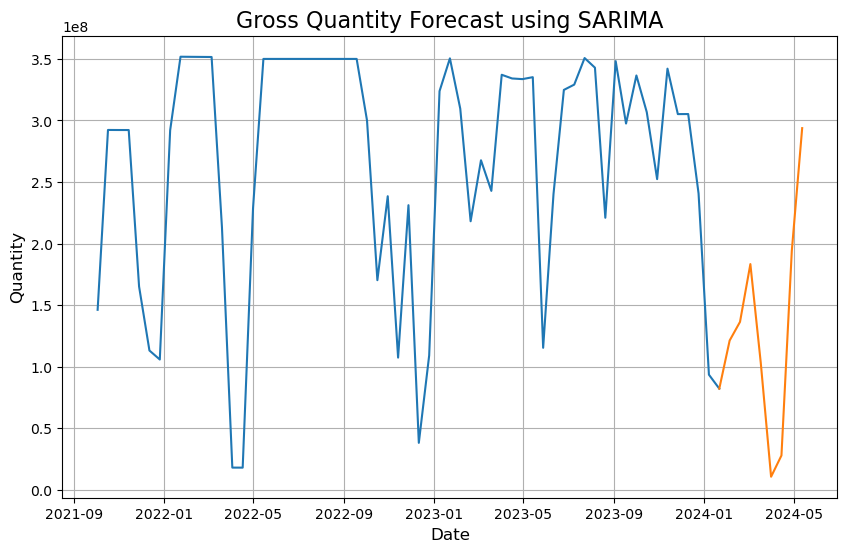

In [259]:
# Extract the last date (index)
last_date_index = tank_205_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_205_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,1,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))
              
new_entry = pd.DataFrame({'Forecast': [tank_205_data_monthly[-1]]}, index=[ tank_205_data_monthly.index[-1]])
future_predictions = new_entry._append(future_predictions).sort_index()

plt.figure(figsize=(10, 6))

plt.plot(tank_205_data_monthly, label='Original Data')
plt.plot(future_predictions, label='Future Predictions')

plt.title('Gross Quantity Forecast using SARIMA', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-206

In [260]:
# Filter the DataFrame for entries with tank code 'TK-206'
tank_206_data = gainloss[gainloss['TANK_CODE'] == 'TK-206']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_206_data['FOLIO_NUMBER'] = pd.to_datetime(tank_206_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_206_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_206_data_monthly = tank_206_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.9258939033614784


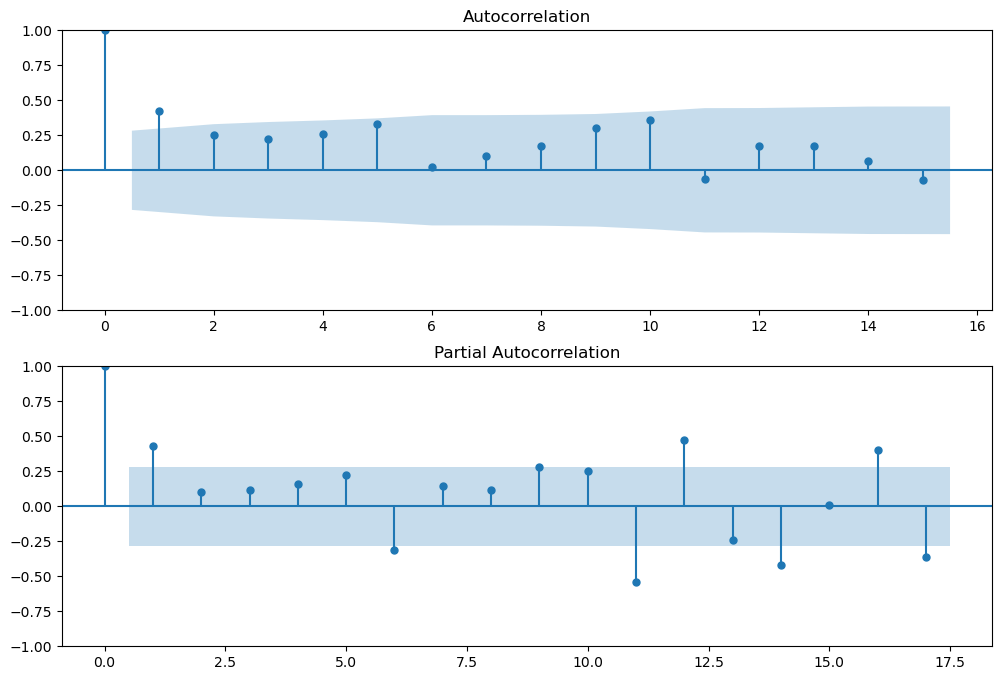

In [265]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_206_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_206_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_206_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 223043001.70199013


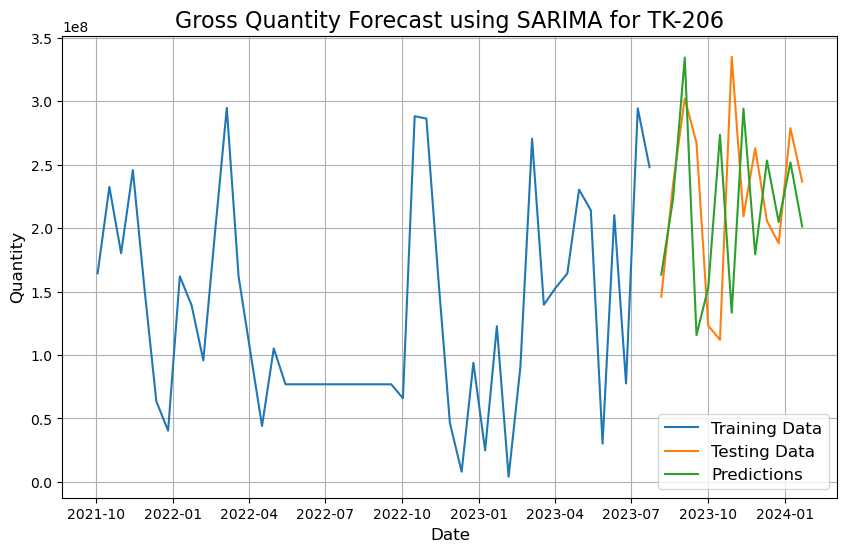

In [270]:
train, test = train_test_split(tank_206_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_206_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(12, 1,0), seasonal_order=(2,0,1,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-206', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

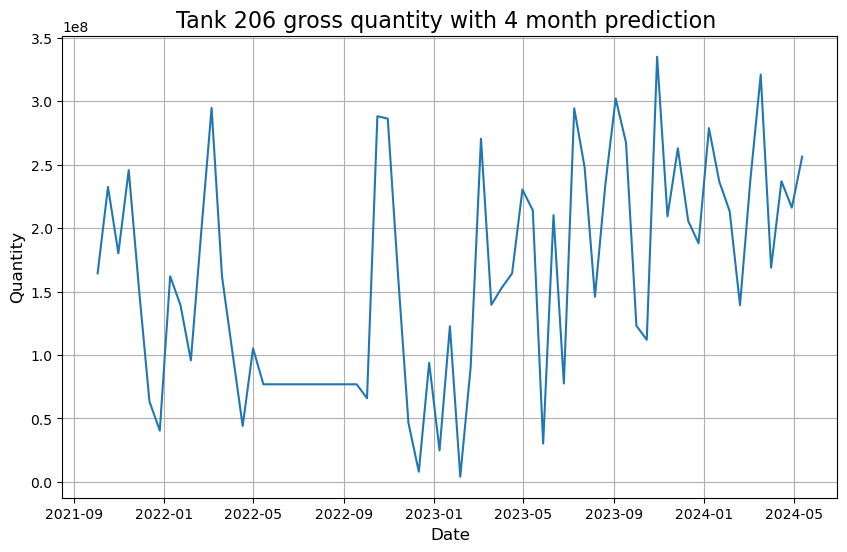

In [266]:
# Extract the last date (index)
last_date_index = tank_206_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_206_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(12, 1,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 206 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-302

In [271]:
# Filter the DataFrame for entries with tank code 'TK-302'
tank_302_data = gainloss[gainloss['TANK_CODE'] == 'TK-302']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_302_data['FOLIO_NUMBER'] = pd.to_datetime(tank_302_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_302_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_302_data_monthly = tank_302_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0007801824452096376


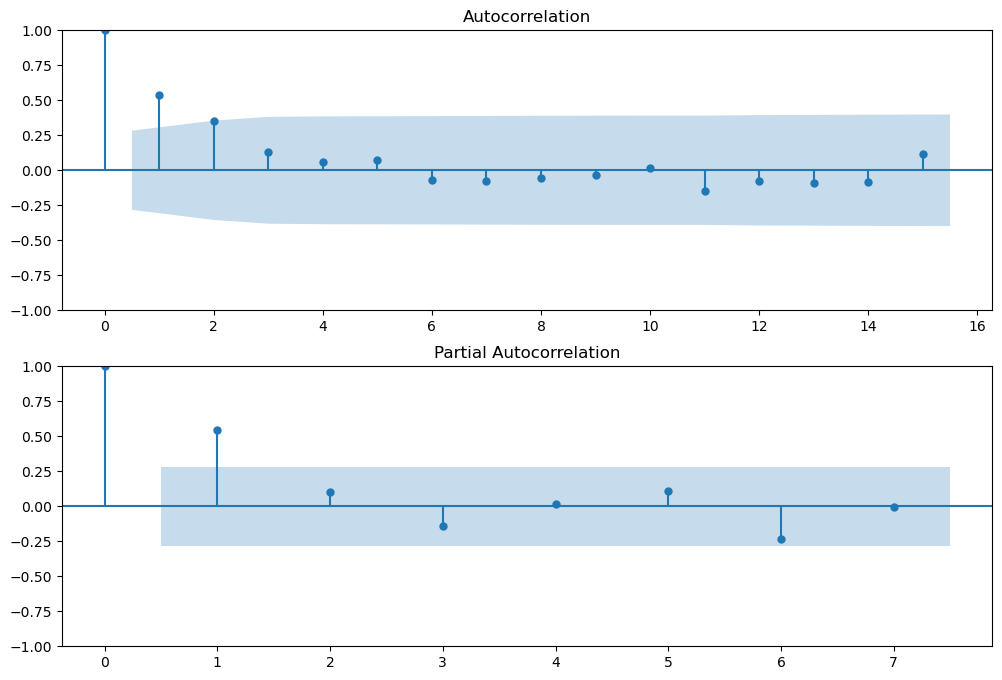

In [272]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_302_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_302_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_302_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 79986388.47723226


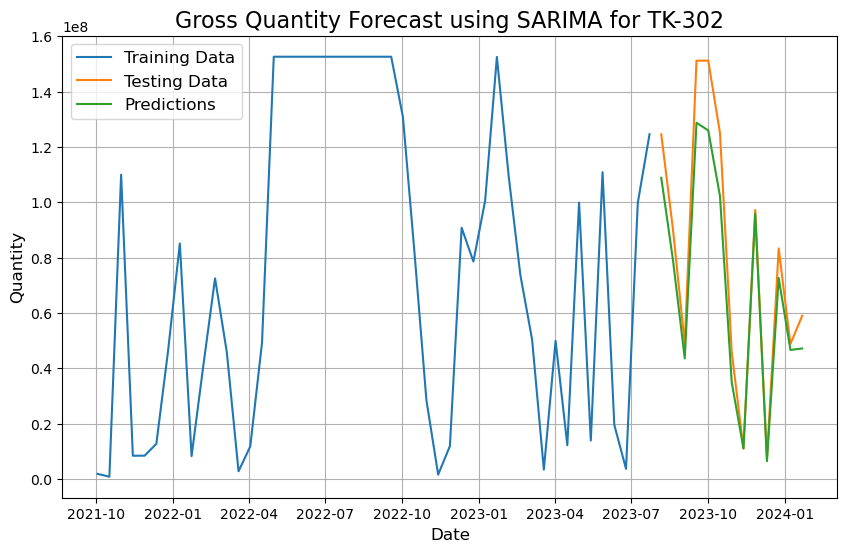

In [273]:
train, test = train_test_split(tank_302_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_302_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-302', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

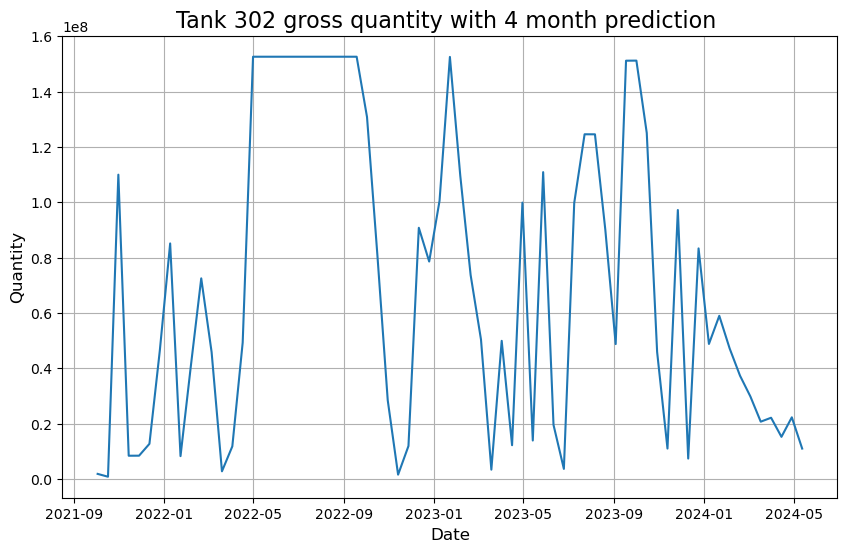

In [274]:
# Extract the last date (index)
last_date_index = tank_302_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_302_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 302 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-303

In [275]:
# Filter the DataFrame for entries with tank code 'TK-303'
tank_303_data = gainloss[gainloss['TANK_CODE'] == 'TK-303']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_303_data['FOLIO_NUMBER'] = pd.to_datetime(tank_303_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_303_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_303_data_monthly = tank_303_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0029694189321297494


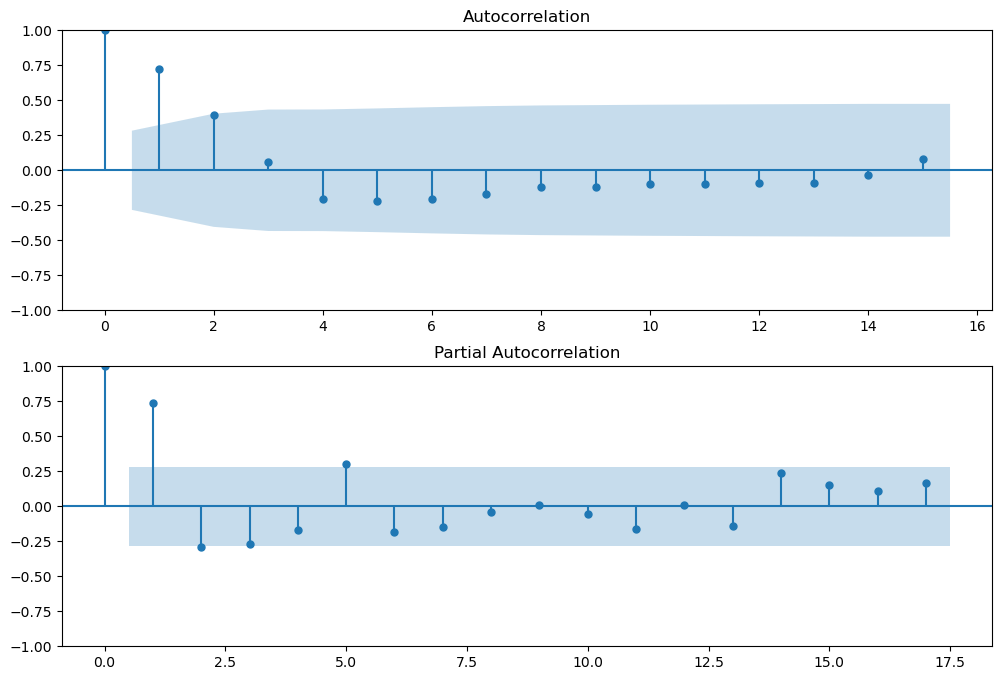

In [286]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_303_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_303_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_303_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 101083958.19778986


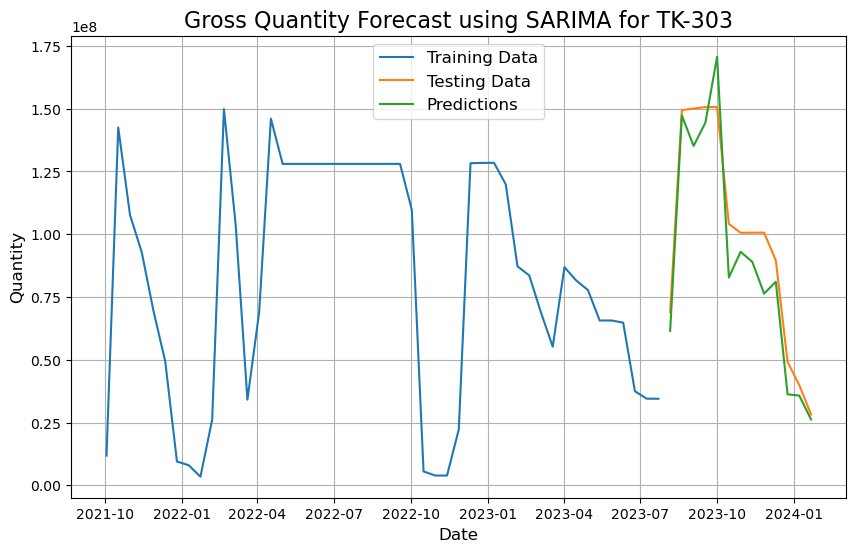

In [288]:
train, test = train_test_split(tank_303_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_303_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-303', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

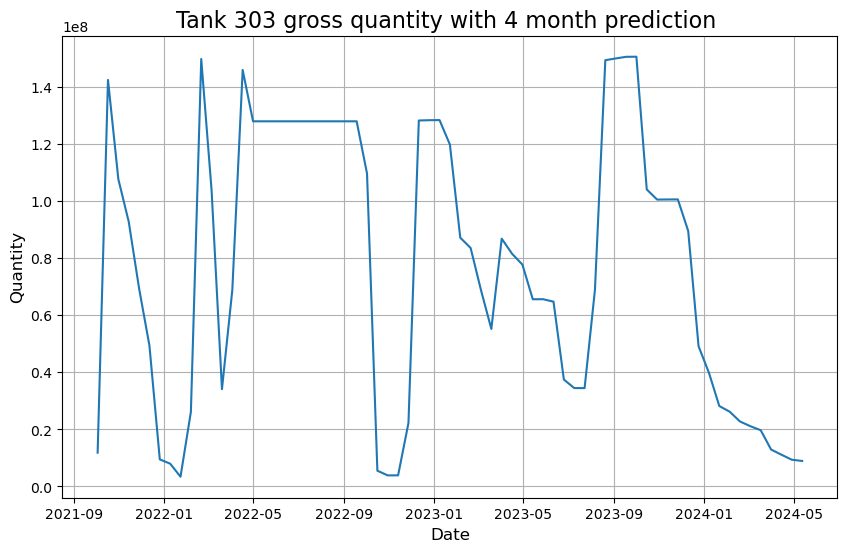

In [289]:
# Extract the last date (index)
last_date_index = tank_303_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_303_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data,  order=(1, 0,1), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 303 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-304

In [290]:
# Filter the DataFrame for entries with tank code 'TK-304'
tank_304_data = gainloss[gainloss['TANK_CODE'] == 'TK-304']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_304_data['FOLIO_NUMBER'] = pd.to_datetime(tank_304_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_304_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_304_data_monthly = tank_304_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0005272659010396816


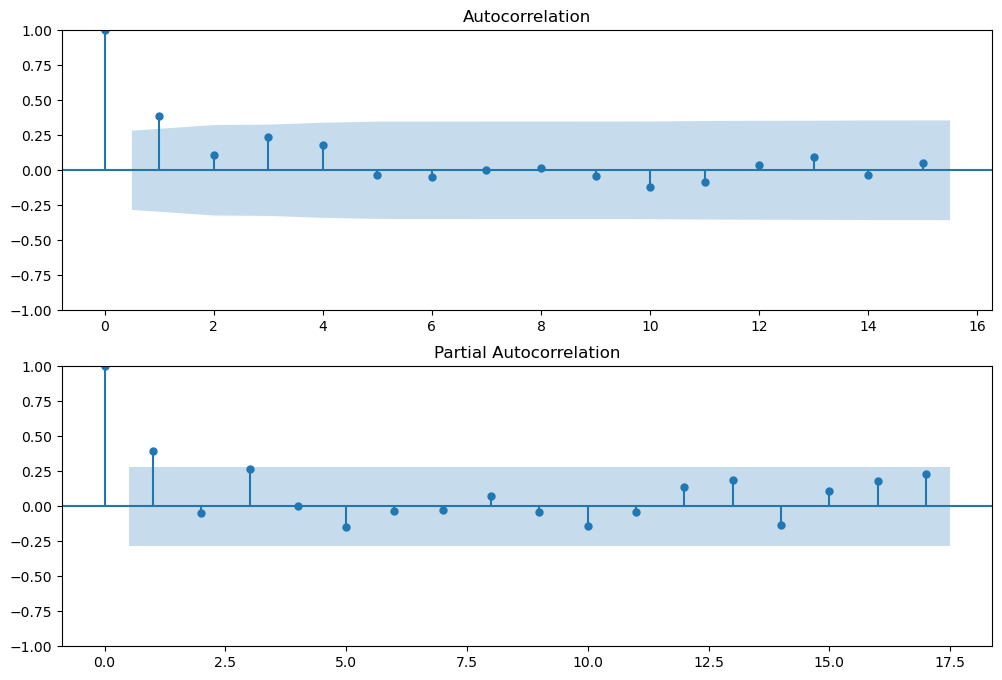

In [294]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_304_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_304_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_304_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 253558697.40500423


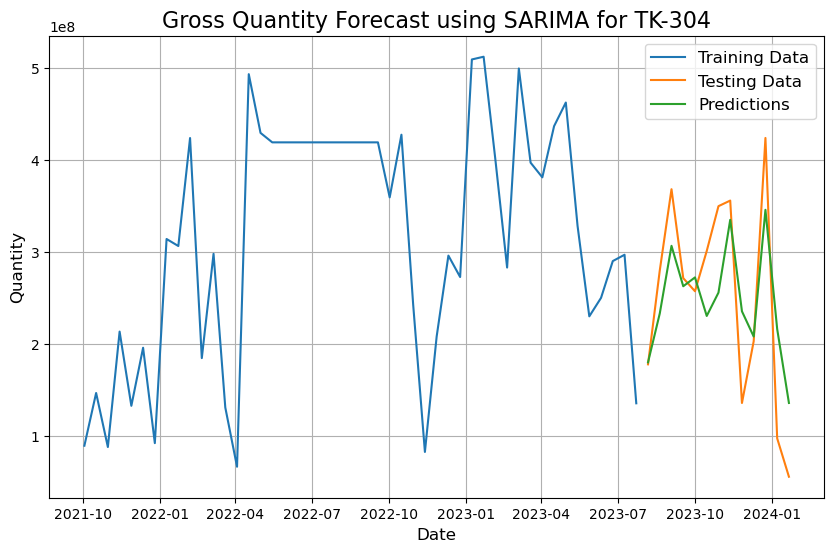

In [300]:
train, test = train_test_split(tank_304_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_304_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-304', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

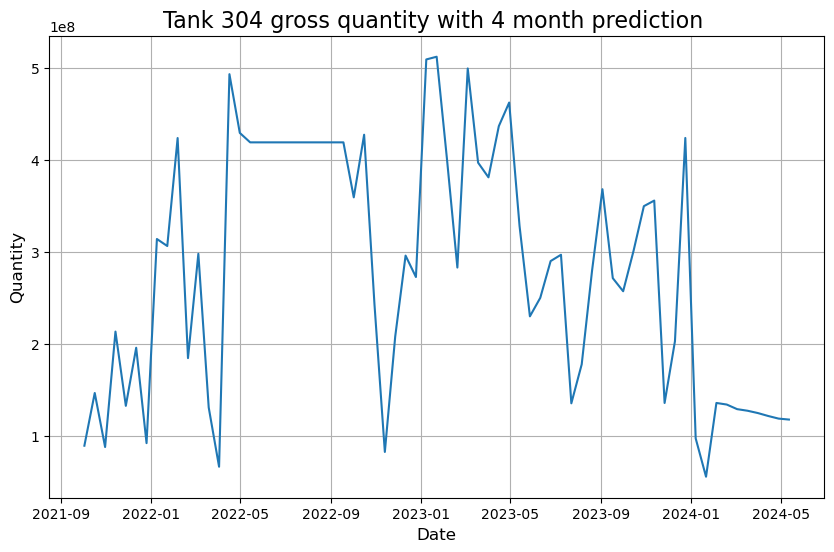

In [299]:
# Extract the last date (index)
last_date_index = tank_304_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_304_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,1), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 304 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-305

In [301]:
# Filter the DataFrame for entries with tank code 'TK-305'
tank_305_data = gainloss[gainloss['TANK_CODE'] == 'TK-305']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_305_data['FOLIO_NUMBER'] = pd.to_datetime(tank_305_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_305_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_305_data_monthly = tank_305_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.17933161340566012


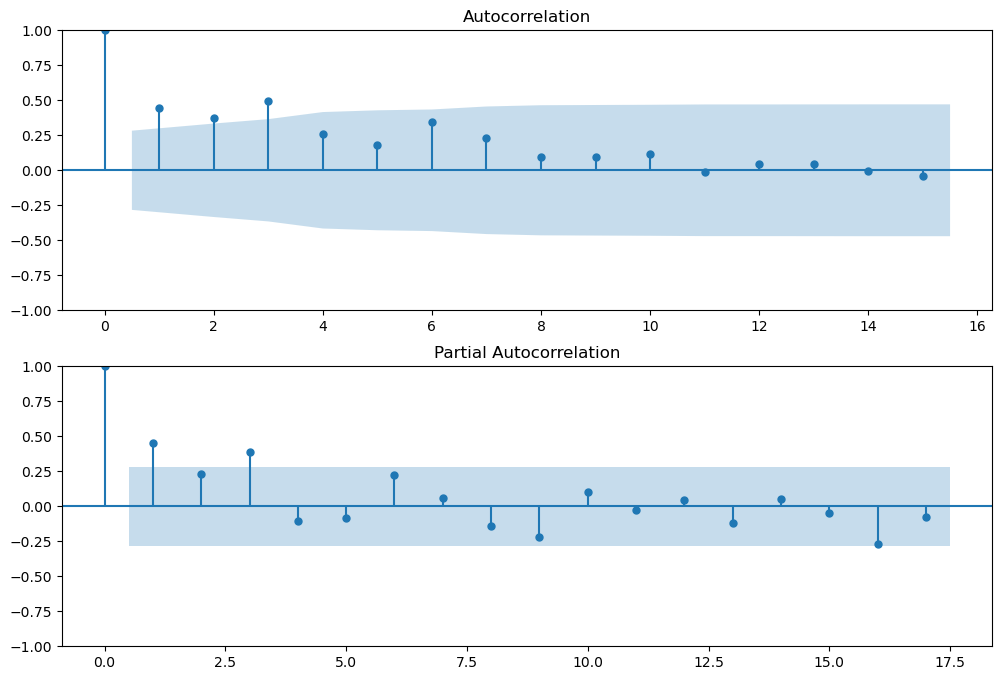

In [305]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_305_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_305_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_305_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 237466175.16029587


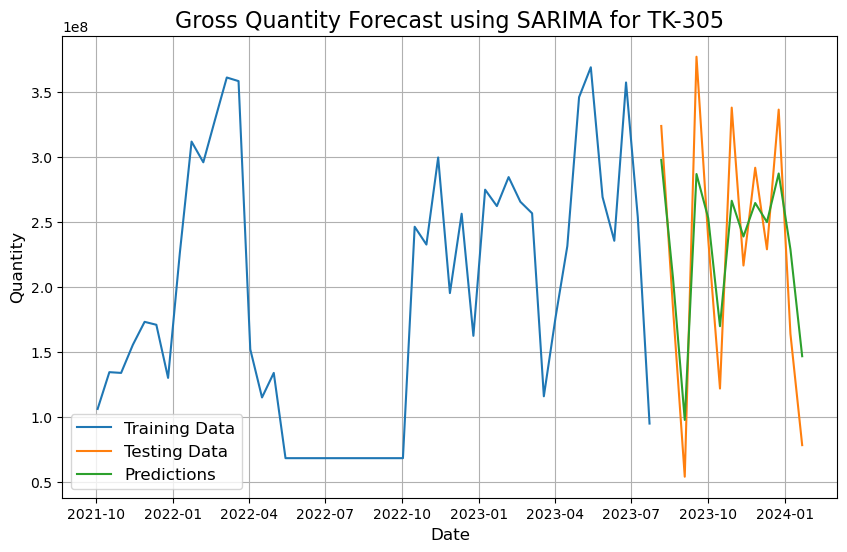

In [313]:
train, test = train_test_split(tank_305_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_305_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 1,1), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-305', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

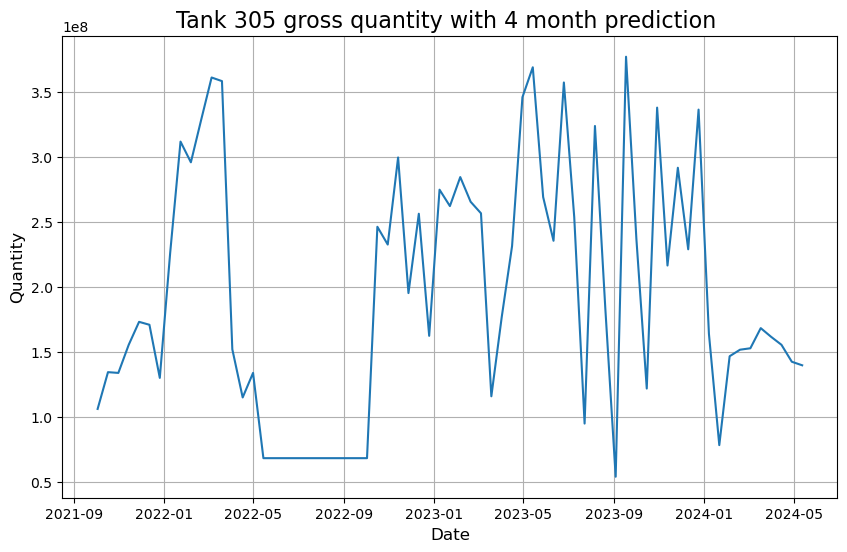

In [314]:
# Extract the last date (index)
last_date_index = tank_305_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_305_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 1,1), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 305 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-306

In [315]:
# Filter the DataFrame for entries with tank code 'TK-306'
tank_306_data = gainloss[gainloss['TANK_CODE'] == 'TK-306']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_306_data['FOLIO_NUMBER'] = pd.to_datetime(tank_306_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_306_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_306_data_monthly = tank_306_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.0004202721365306991


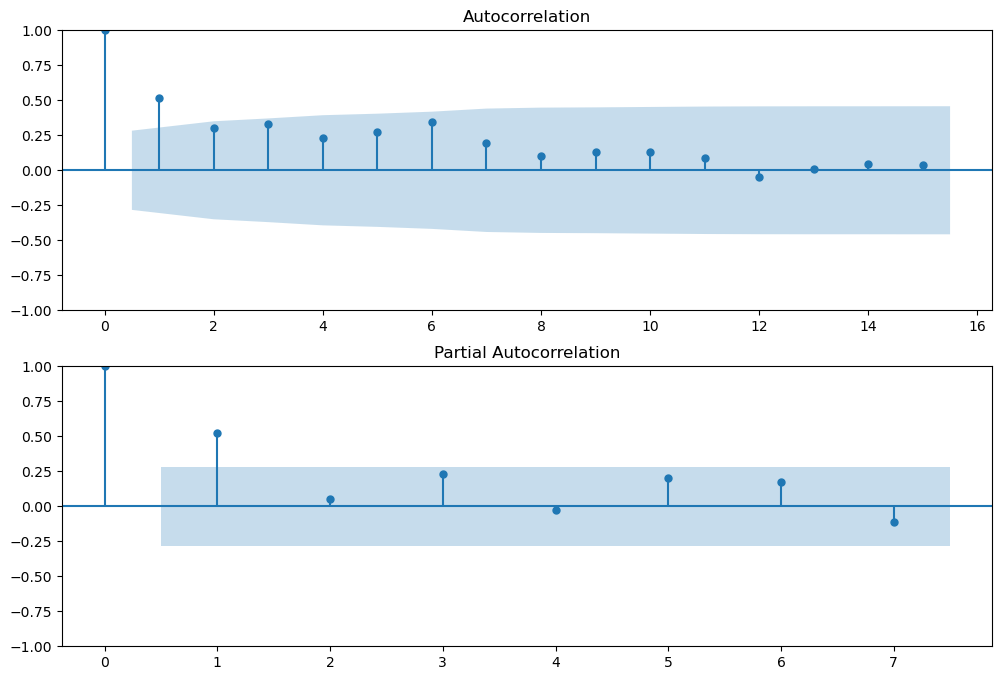

In [316]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_306_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_306_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_306_data_monthly.iloc[13:], lags=7, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 198045248.44885308


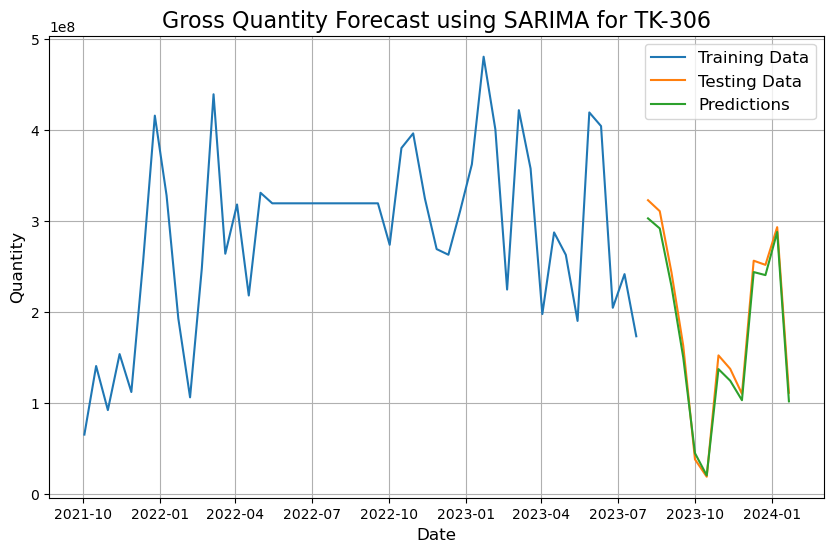

In [317]:
train, test = train_test_split(tank_306_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_306_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-306', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

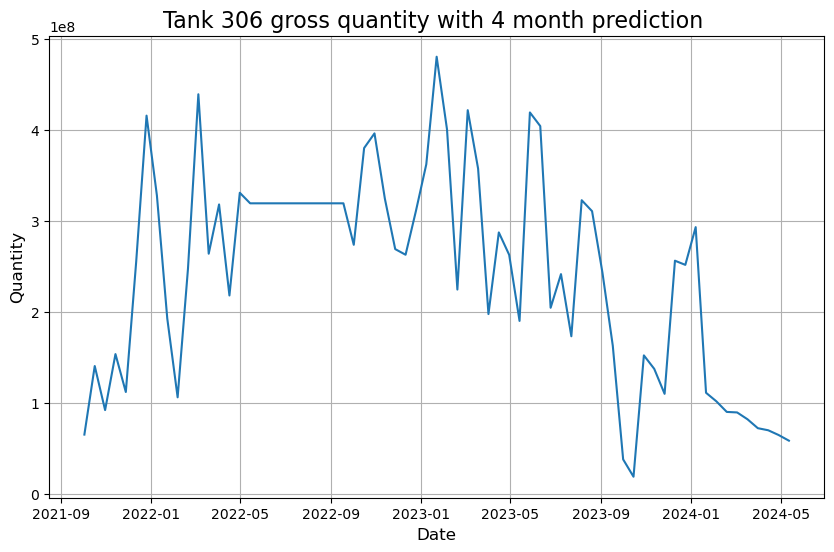

In [320]:
# Extract the last date (index)
last_date_index = tank_306_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_306_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 306 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

# TK-307

In [321]:
# Filter the DataFrame for entries with tank code 'TK-307'
tank_307_data = gainloss[gainloss['TANK_CODE'] == 'TK-307']

# Convert 'FOLIO_NUMBER' to datetime if it's not already in datetime format
tank_307_data['FOLIO_NUMBER'] = pd.to_datetime(tank_307_data['FOLIO_NUMBER'])

# Set 'FOLIO_NUMBER' as the index
tank_307_data.set_index('FOLIO_NUMBER', inplace=True)

# Resample the data to monthly frequency and take the last value of each month
tank_307_data_monthly = tank_307_data.resample('2W')['CLOSING_PHYSICAL'].sum()

p-value: 0.35444010037360163


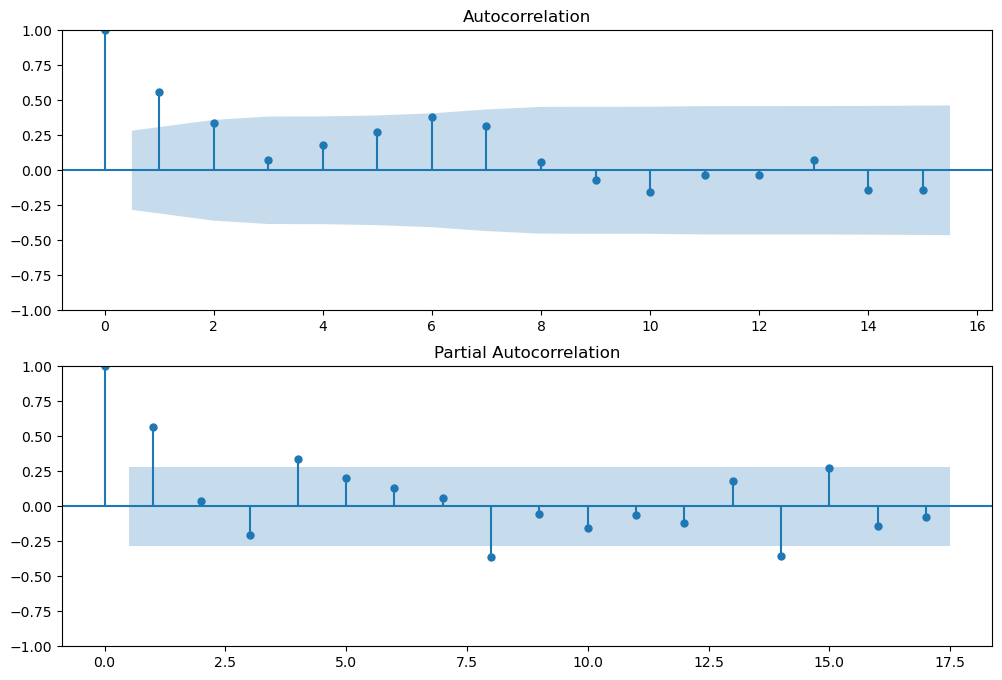

In [326]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Perform Augmented Dickey-Fuller test
result = adfuller(tank_307_data_monthly)
print('p-value:', result[1])
# Data is stationary

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(tank_307_data_monthly.iloc[13:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(tank_307_data_monthly.iloc[13:], lags=17, ax=ax2)
plt.show()

Root Mean Squared Error (RMSE) on test data: 299704894.0832365


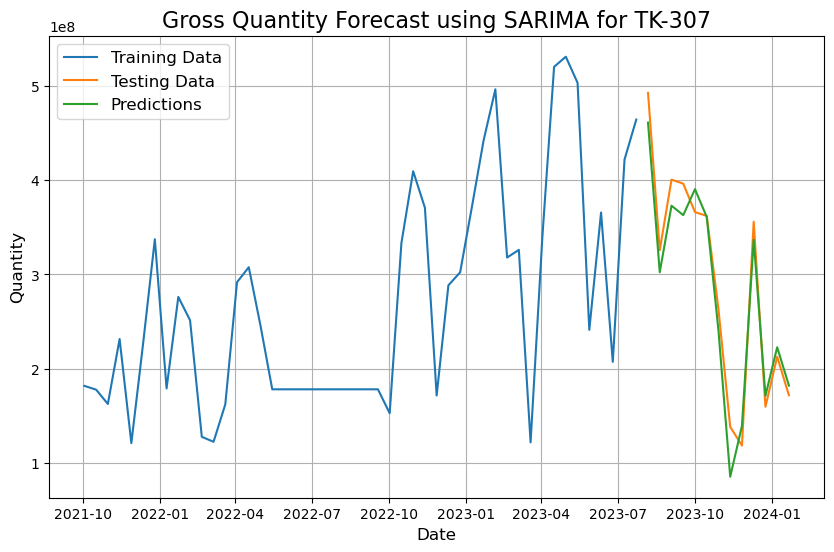

In [323]:
train, test = train_test_split(tank_307_data_monthly, test_size=0.2, shuffle=False)

rolling_predictions = test.copy()
for end_date in test.index:
    train_data = tank_307_data_monthly[:end_date]  # Include end_date in training data
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).astype(int)  # Forecast one step ahead
        rolling_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
    except Exception as e:
        # Handle specific exceptions
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

rolling_residuals = test - rolling_predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, rolling_residuals))
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_predictions, label='Predictions')

plt.legend(fontsize=12)
plt.title('Gross Quantity Forecast using SARIMA for TK-307', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()

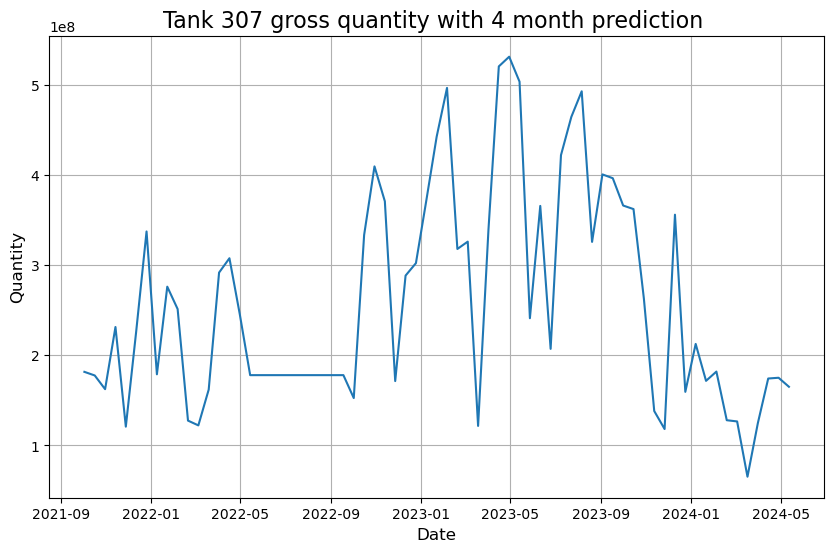

In [324]:
# Extract the last date (index)
last_date_index = tank_307_data_monthly.index[-1]

# Convert the last date to a datetime object
last_date_dt = pd.to_datetime(last_date_index)

# Generate 8 dates with a 2-week step starting from the day after the last date
next_dates = pd.date_range(start=last_date_dt + pd.DateOffset(days=14), periods=8, freq='2W')

# Convert the next_dates to a datetime index
next_dates = pd.to_datetime(next_dates)

# Create a Series with future dates as the index
future_series = pd.Series(index=next_dates)

# Initialize an empty dataframe to store predictions
future_predictions = pd.DataFrame(index=future_series.index, columns=['Forecast'])

# Initial training data
train_data = tank_307_data_monthly

# Fitting the model and making predictions for each future date
for end_date in future_series.index:
    try:
        model = SARIMAX(train_data, order=(1, 0,0), seasonal_order=(1,0,0,26))  # SARIMA with seasonal component
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)  # Forecast one step ahead
        future_predictions.loc[end_date] = pred[0]  # Assign forecasted value to correct index
        train_data = train_data._append(pd.Series(pred[0], index=[end_date]))
    except Exception as e:
        print("Error occurred for date:", end_date)
        print("Error details:", str(e))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data)
plt.title('Tank 307 gross quantity with 4 month prediction ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True)
plt.show()